# CREACIÓN DEL DATAMART ANALÍTICO

Haremos calidad de datos individual de cada tabla porque, si  el volumen de información de cada tabla fuera muy alto, al unirlos todavía se multiplica más.

Por tanto inicialmente las dejaramos como tablas individuales, después aplicaremos calidad de datos y finalmente las uniremos para forma el tablón o más oficialmente el datamart analítico.

1. Acceder a la base de datos
2. Importar los datos como dataframes de Pandas
3. Realizar la calidad de datos
4. Crear el datamart analítico
5. Guardarlo como una tabla en la base de datos para no tener que repetir el proceso

## SET UP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlalchemy as sa
from janitor import clean_names

#Automcompletar rápido
%config IPCompleter.greedy=True

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 400)
pd.options.display.float_format = '{:15.2f}'.format 

## IMPORTACION DE DATOS

### Datos internos

Crear la conexión a la base de datos

In [2]:
con = sa.create_engine('sqlite:///../../02_Datos/01_Originales/airbnb2025.db')

In [ ]:
listings.to_sql('listings', con = con, if_exists = 'replace')
listings_det.to_sql('listings_det', con = con, if_exists = 'replace')
calendar.to_sql('calendar', con = con, if_exists = 'replace')
neigh.to_sql('neigh', con = con, if_exists = 'replace')

Inspeccionar los nombres de las tablas:

In [3]:
from sqlalchemy import inspect
insp = inspect(con)
tablas = insp.get_table_names()
tablas

['calendar',
 'cat',
 'df_preparado',
 'listings',
 'listings_det',
 'neigh',
 'num',
 'precio_m2',
 'target']

Cargar las tablas

In [5]:
for tabla in tablas:
    exec(f'{tabla} = pd.read_sql(tabla, con)')

Dimensiones de las tablas de la db seleccionada:

In [6]:
for cada in tablas:
    print(cada + ': ' + str(eval(cada).shape))

calendar: (9767270, 8)
cat: (25913, 16)
df_preparado: (25913, 63)
listings: (26760, 19)
listings_det: (26760, 76)
neigh: (128, 3)
num: (25913, 39)
precio_m2: (21, 3)
target: (25913, 2)


### Datos Externos

En nuestros datos no tenemos el precio de compra de un inmueble, pero habíamos visto que es una de las palancas principales.

Por tanto vasos a buscar esos datos de forma externa.

En esta página tenemos justo la info que necesitamos: https://www.idealista.com/sala-de-prensa/informes-precio-vivienda/venta/madrid-comunidad/madrid-provincia/madrid/

Podemos extraerla de forma sencilla con el plugin instant data scraper de Chrome, y guardarla en nuestra carpeta Datos con el nombre 'precios_idealista.csv'

In [7]:
precio_m2 = pd.read_csv('../../02_Datos/01_Originales/precios_idealista_Dic24.csv')
precio_m2

,table__cell,table__cell 2,table__cell 3,table__cell 4,table__cell 5,table__cell 6,table__cell 7,icon-elbow,icon-elbow href
0,Madrid,4.514 €/m2,"+ 0,9 %","+ 4,1 %","+ 12,4 %",4.514 €/m2 jun 2024,"0,0 %",NaN,NaN
1,NaN,4.850 €/m2,"+ 2,0 %","+ 5,6 %","+ 10,4 %",4.850 €/m2 jun 2024,"0,0 %",Arganzuela,https://www.idealista.com/sala-de-prensa/infor...
2,NaN,3.686 €/m2,"+ 0,3 %","+ 3,9 %","+ 5,1 %",3.686 €/m2 mar 2009,"0,0 %",Barajas,https://www.idealista.com/sala-de-prensa/infor...
3,"- 14,5 %",2.712 €/m2,"+ 1,4 %","+ 3,8 %","+ 10,4 %",3.173 €/m2 jun 2007,NaN,Carabanchel,https://www.idealista.com/sala-de-prensa/infor...
4,"- 0,6 %",6.170 €/m2,"+ 0,4 %","+ 14,9 %","- 0,8 %",6.221 €/m2 abr 2024,NaN,Centro,https://www.idealista.com/sala-de-prensa/infor...
5,NaN,6.285 €/m2,"+ 1,1 %","+ 4,1 %","+ 10,2 %",6.285 €/m2 jun 2024,"0,0 %",Chamartín,https://www.idealista.com/sala-de-prensa/infor...
6,NaN,6.665 €/m2,"+ 0,5 %","+ 5,0 %","+ 12,2 %",6.665 €/m2 jun 2024,"0,0 %",Chamberí,https://www.idealista.com/sala-de-prensa/infor...
7,NaN,3.676 €/m2,"+ 0,9 %","+ 5,1 %","+ 8,7 %",3.676 €/m2 jun 2024,"0,0 %",Ciudad Lineal,https://www.idealista.com/sala-de-prensa/infor...
8,NaN,4.038 €/m2,"+ 0,8 %","+ 3,3 %","+ 5,4 %",4.038 €/m2 jun 2024,"0,0 %",Fuencarral,https://www.idealista.com/sala-de-prensa/infor...
9,NaN,4.368 €/m2,"+ 0,8 %","+ 5,7 %","+ 9,6 %",4.368 €/m2 jun 2024,"0,0 %",Hortaleza,https://www.idealista.com/sala-de-prensa/infor...


Cargamos los datos, quitamos el primer registro y seleccionamos solo las columnas de precio y distrito

In [8]:
precio_m2 = pd.read_csv('../../02_Datos/01_Originales/precios_idealista_Dic24.csv') \
    .loc[1:,['table__cell 2','icon-elbow']] \
    .rename(columns = {'table__cell 2':'precio_m2','icon-elbow':'distrito'})
precio_m2

,precio_m2,distrito
1,4.850 €/m2,Arganzuela
2,3.686 €/m2,Barajas
3,2.712 €/m2,Carabanchel
4,6.170 €/m2,Centro
5,6.285 €/m2,Chamartín
6,6.665 €/m2,Chamberí
7,3.676 €/m2,Ciudad Lineal
8,4.038 €/m2,Fuencarral
9,4.368 €/m2,Hortaleza
10,2.772 €/m2,Latina


In [9]:
precio_m2['precio_m2'] = precio_m2['precio_m2'].str.replace(' €/m2','').str.replace('.','').astype('int')

In [10]:
precio_m2

,precio_m2,distrito
1,4850,Arganzuela
2,3686,Barajas
3,2712,Carabanchel
4,6170,Centro
5,6285,Chamartín
6,6665,Chamberí
7,3676,Ciudad Lineal
8,4038,Fuencarral
9,4368,Hortaleza
10,2772,Latina


Limpiamos el precio:
    
1. quitando la unidad
2. quitando los puntos de separador de miles
3. cambiando el tipo a entero

## CALIDAD DE DATOS

### Tabla listings & listings_det

#### Visión general

In [11]:
listings.head()

,index,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,0,21853,Bright and airy room,83531,Abdel,Latina,Cármenes,40.40,-3.74,Private room,31.00,4,33,2018-07-15,0.27,2,144,0,None
1,1,30320,Great Vacational Apartments,130907,Dana,Centro,Sol,40.41,-3.70,Entire home/apt,NaN,5,172,2022-09-26,0.98,3,0,0,None
2,2,30959,Beautiful loft in Madrid Center,132883,Angela,Centro,Embajadores,40.41,-3.70,Entire home/apt,NaN,3,8,2017-05-30,0.07,1,0,0,None
3,3,40916,Holiday Apartment Madrid Center,130907,Dana,Centro,Universidad,40.42,-3.71,Entire home/apt,NaN,5,49,2021-12-11,0.29,3,0,0,None
4,4,62423,MAGIC ARTISTIC HOUSE IN THE CENTER OF MADRID,303845,Arturo,Centro,Justicia,40.42,-3.70,Private room,69.00,1,219,2024-11-24,2.73,3,332,44,None


In [12]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26760 entries, 0 to 26759
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           26760 non-null  int64  
 1   id                              26760 non-null  int64  
 2   name                            26760 non-null  object 
 3   host_id                         26760 non-null  int64  
 4   host_name                       26757 non-null  object 
 5   neighbourhood_group             26760 non-null  object 
 6   neighbourhood                   26760 non-null  object 
 7   latitude                        26760 non-null  float64
 8   longitude                       26760 non-null  float64
 9   room_type                       26760 non-null  object 
 10  price                           20815 non-null  float64
 11  minimum_nights                  26760 non-null  int64  
 12  number_of_reviews               

In [13]:
listings_det.head()

,index,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,0,21853,https://www.airbnb.com/rooms/21853,20241212051353,2024-12-12,city scrape,Bright and airy room,We have a quiet and sunny room with a good vie...,We live in a leafy neighbourhood with plenty o...,https://a0.muscache.com/pictures/68483181/87bc...,83531,https://www.airbnb.com/users/show/83531,Abdel,2010-02-21,"Madrid, Spain",EN-ES-FR\r\nEN\r\nHi everybody: I'm Abdel. I'm...,None,None,0%,f,https://a0.muscache.com/im/users/83531/profile...,https://a0.muscache.com/im/users/83531/profile...,Aluche,2.00,2.00,"['email', 'phone']",t,t,"Madrid, Spain",Cármenes,Latina,40.40,-3.74,Private room in rental unit,Private room,1,1.00,1 bath,1.00,1.00,"[""First aid kit"", ""Wifi"", ""Kitchen"", ""Essentia...",$31.00,4,40,4,4,40,40,4.00,40.00,NaN,t,0,0,0,144,2024-12-12,33,0,0,2014-10-10,2018-07-15,4.58,4.72,4.56,4.75,4.82,4.21,4.67,None,f,2,0,2,0,0.27
1,1,30320,https://www.airbnb.com/rooms/30320,20241212051353,2024-12-12,previous scrape,Great Vacational Apartments,None,None,https://a0.muscache.com/pictures/336868/f67409...,130907,https://www.airbnb.com/users/show/130907,Dana,2010-05-24,"Madrid, Spain",Apartasol offers a network of several spacious...,None,None,None,f,https://a0.muscache.com/im/users/130907/profil...,https://a0.muscache.com/im/users/130907/profil...,Sol,3.00,6.00,"['email', 'phone']",t,f,None,Sol,Centro,40.41,-3.70,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.00,NaN,"[""Heating"", ""Wifi"", ""TV with standard cable"", ...",None,5,180,5,5,180,180,5.00,180.00,NaN,None,0,0,0,0,2024-12-12,172,0,0,2010-07-06,2022-09-26,4.63,4.71,4.88,4.82,4.78,4.90,4.69,None,f,3,3,0,0,0.98
2,2,30959,https://www.airbnb.com/rooms/30959,20241212051353,2024-12-12,previous scrape,Beautiful loft in Madrid Center,Beautiful Loft 60m2 size just in the historica...,None,https://a0.muscache.com/pictures/78173471/835e...,132883,https://www.airbnb.com/users/show/132883,Angela,2010-05-26,"Madrid, Spain",Estoy empezando en Airbnb y deseo que mis hués...,None,None,None,f,https://a0.muscache.com/im/users/132883/profil...,https://a0.muscache.com/im/users/132883/profil...,Embajadores,1.00,4.00,"['email', 'phone']",t,f,None,Embajadores,Centro,40.41,-3.70,Entire loft,Entire home/apt,2,NaN,1 bath,1.00,NaN,"[""Breakfast"", ""Heating"", ""Wifi"", ""Smoking allo...",None,3,730,3,3,730,730,3.00,730.00,NaN,None,0,0,0,0,2024-12-12,8,0,0,2015-05-12,2017-05-30,4.38,4.14,4.38,4.63,4.63,4.88,4.25,None,f,1,1,0,0,0.07
3,3,40916,https://www.airbnb.com/rooms/40916,20241212051353,2024-12-12,previous scrape,Holiday Apartment Madrid Center,None,None,https://a0.muscache.com/pictures/336736/c3b486...,130907,https://www.airbnb.com/users/show/130907,Dana,2010-05-24,"Madrid, Sp

In [14]:
listings_det.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26760 entries, 0 to 26759
Data columns (total 76 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   index                                         26760 non-null  int64  
 1   id                                            26760 non-null  int64  
 2   listing_url                                   26760 non-null  object 
 3   scrape_id                                     26760 non-null  int64  
 4   last_scraped                                  26760 non-null  object 
 5   source                                        26760 non-null  object 
 6   name                                          26760 non-null  object 
 7   description                                   25740 non-null  object 
 8   neighborhood_overview                         12228 non-null  object 
 9   picture_url                                   26759 non-null 

In [15]:
listings.isna().sum().sort_values(ascending=False)

license                           24120
price                              5945
reviews_per_month                  5467
last_review                        5467
host_name                             3
number_of_reviews_ltm                 0
availability_365                      0
calculated_host_listings_count        0
number_of_reviews                     0
minimum_nights                        0
index                                 0
id                                    0
longitude                             0
latitude                              0
neighbourhood                         0
neighbourhood_group                   0
host_id                               0
name                                  0
room_type                             0
dtype: int64

In [16]:
listings_det.isna().sum().sort_values(ascending=False)

calendar_updated                                26760
license                                         24120
host_neighbourhood                              17607
neighborhood_overview                           14532
neighbourhood                                   14532
host_about                                      13401
host_location                                    8203
price                                            5945
beds                                             5932
bathrooms                                        5926
review_scores_value                              5471
review_scores_location                           5470
review_scores_checkin                            5468
review_scores_cleanliness                        5468
reviews_per_month                                5467
first_review                                     5467
review_scores_rating                             5467
review_scores_accuracy                           5467
review_scores_communication 

listings_det contiene toda la información de listings con mas detalle, por lo que vamos a trabajar con listings_det ya que tiene variables que nos vendrán mejor para realizar predicciones

#### Variables y tipos

Vamos a eliminar aquellas variables que no nos sirven para las predicciones o son repetitivas

In [17]:
a_eliminar = ['index',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'source',
 'description',
 'neighborhood_overview',
 'picture_url',
 'host_url',
 'host_name',
 'host_location',
 'host_about',
 'host_picture_url',
 'host_neighbourhood',
 'neighbourhood',
 'neighbourhood_group_cleansed',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'calendar_updated',
 'calendar_last_scraped',
 'host_thumbnail_url']

listings_det = listings_det.drop(columns = a_eliminar)
listings_det

,id,name,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,21853,Bright and airy room,83531,2010-02-21,None,None,0%,f,2.00,2.00,"['email', 'phone']",t,t,Cármenes,40.40,-3.74,Private room in rental unit,Private room,1,1.00,1 bath,1.00,1.00,"[""First aid kit"", ""Wifi"", ""Kitchen"", ""Essentia...",$31.00,4,40,t,0,0,0,144,33,0,0,2014-10-10,2018-07-15,4.58,4.72,4.56,4.75,4.82,4.21,4.67,None,f,2,0,2,0,0.27
1,30320,Great Vacational Apartments,130907,2010-05-24,None,None,None,f,3.00,6.00,"['email', 'phone']",t,f,Sol,40.41,-3.70,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.00,NaN,"[""Heating"", ""Wifi"", ""TV with standard cable"", ...",None,5,180,None,0,0,0,0,172,0,0,2010-07-06,2022-09-26,4.63,4.71,4.88,4.82,4.78,4.90,4.69,None,f,3,3,0,0,0.98
2,30959,Beautiful loft in Madrid Center,132883,2010-05-26,None,None,None,f,1.00,4.00,"['email', 'phone']",t,f,Embajadores,40.41,-3.70,Entire loft,Entire home/apt,2,NaN,1 bath,1.00,NaN,"[""Breakfast"", ""Heating"", ""Wifi"", ""Smoking allo...",None,3,730,None,0,0,0,0,8,0,0,2015-05-12,2017-05-30,4.38,4.14,4.38,4.63,4.63,4.88,4.25,None,f,1,1,0,0,0.07
3,40916,Holiday Apartment Madrid Center,130907,2010-05-24,None,None,None,f,3.00,6.00,"['email', 'phone']",t,f,Universidad,40.42,-3.71,Entire rental unit,Entire home/apt,3,NaN,1 bath,1.00,NaN,"[""Heating"", ""Wifi"", ""Pets allowed"", ""Kitchen"",...",None,5,180,None,0,0,0,0,49,0,0,2010-11-01,2021-12-11,4.65,4.69,4.90,4.85,4.79,4.88,4.55,None,f,3,3,0,0,0.29
4,62423,MAGIC ARTISTIC HOUSE IN THE CENTER OF MADRID,303845,2010-11-29,within an hour,100%,100%,f,3.00,3.00,"['email', 'phone']",t,t,Justicia,40.42,-3.70,Private room in rental unit,Private room,4,1.50,1.5 shared baths,1.00,2.00,"[""Books and reading material"", ""First aid kit""...",$69.00,1,30,t,13,37,59,332,219,44,3,2018-05-10,2024-11-24,4.64,4.78,4.42,4.79,4.85,4.97,4.58,None,f,3,1,2,0,2.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26755,1308816654087147793,Vive Madrid Río con Confort y Estilo,251333188,2019-03-26,within a few hours,100%,67%,None,163.00,234.00,"['email', 'phone']",t,t,Puerta del Angel,40.41,-3.72,Entire rental unit,Entire home/apt,4,1.00,1 bath,1.00,2.00,"[""Wifi"", ""Kitchen"", ""Hot water"", ""Microwave"", ...",$258.00,1,365,t,15,45,75,350,0,0,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,t,19,19,0,0,NaN
26756,1308818613904246041,Alquilo habitación por 15 días.,118339834,2017-02-27,None,None,None,f,1.00,1.00,"['email', 'phone']",t,t,Palacio,40.41,-3.71,Private room in rental unit,Private room,1,1.00,1 shared bath,1.00,1.00,"[""Wifi"", ""Kitchen"", ""TV""]",$20.00,15,16,t,29,59,89,364,0,0,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,f,1,0,1,0,NaN
26757,1308839477505592914,Sierra Habitacion doble con Baño Privado,23441165,2014-11-07,within an hour,95%,98%,f,39.00,90.00,"['email', 'phone']",t,t,Numancia,40.40,-3.66,Room in hotel,Private room,2,1.00,1 private bath,1.00,1.00,"[""Exterior security cameras on property"", ""Smo...",$69.00,1,365,t,14,44,74,309,0,0,0,None,Non

In [18]:
listings_det = clean_names(listings_det)
listings_det

,id,name,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,21853,Bright and airy room,83531,2010-02-21,None,None,0%,f,2.00,2.00,"['email', 'phone']",t,t,Cármenes,40.40,-3.74,Private room in rental unit,Private room,1,1.00,1 bath,1.00,1.00,"[""First aid kit"", ""Wifi"", ""Kitchen"", ""Essentia...",$31.00,4,40,t,0,0,0,144,33,0,0,2014-10-10,2018-07-15,4.58,4.72,4.56,4.75,4.82,4.21,4.67,None,f,2,0,2,0,0.27
1,30320,Great Vacational Apartments,130907,2010-05-24,None,None,None,f,3.00,6.00,"['email', 'phone']",t,f,Sol,40.41,-3.70,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.00,NaN,"[""Heating"", ""Wifi"", ""TV with standard cable"", ...",None,5,180,None,0,0,0,0,172,0,0,2010-07-06,2022-09-26,4.63,4.71,4.88,4.82,4.78,4.90,4.69,None,f,3,3,0,0,0.98
2,30959,Beautiful loft in Madrid Center,132883,2010-05-26,None,None,None,f,1.00,4.00,"['email', 'phone']",t,f,Embajadores,40.41,-3.70,Entire loft,Entire home/apt,2,NaN,1 bath,1.00,NaN,"[""Breakfast"", ""Heating"", ""Wifi"", ""Smoking allo...",None,3,730,None,0,0,0,0,8,0,0,2015-05-12,2017-05-30,4.38,4.14,4.38,4.63,4.63,4.88,4.25,None,f,1,1,0,0,0.07
3,40916,Holiday Apartment Madrid Center,130907,2010-05-24,None,None,None,f,3.00,6.00,"['email', 'phone']",t,f,Universidad,40.42,-3.71,Entire rental unit,Entire home/apt,3,NaN,1 bath,1.00,NaN,"[""Heating"", ""Wifi"", ""Pets allowed"", ""Kitchen"",...",None,5,180,None,0,0,0,0,49,0,0,2010-11-01,2021-12-11,4.65,4.69,4.90,4.85,4.79,4.88,4.55,None,f,3,3,0,0,0.29
4,62423,MAGIC ARTISTIC HOUSE IN THE CENTER OF MADRID,303845,2010-11-29,within an hour,100%,100%,f,3.00,3.00,"['email', 'phone']",t,t,Justicia,40.42,-3.70,Private room in rental unit,Private room,4,1.50,1.5 shared baths,1.00,2.00,"[""Books and reading material"", ""First aid kit""...",$69.00,1,30,t,13,37,59,332,219,44,3,2018-05-10,2024-11-24,4.64,4.78,4.42,4.79,4.85,4.97,4.58,None,f,3,1,2,0,2.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26755,1308816654087147793,Vive Madrid Río con Confort y Estilo,251333188,2019-03-26,within a few hours,100%,67%,None,163.00,234.00,"['email', 'phone']",t,t,Puerta del Angel,40.41,-3.72,Entire rental unit,Entire home/apt,4,1.00,1 bath,1.00,2.00,"[""Wifi"", ""Kitchen"", ""Hot water"", ""Microwave"", ...",$258.00,1,365,t,15,45,75,350,0,0,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,t,19,19,0,0,NaN
26756,1308818613904246041,Alquilo habitación por 15 días.,118339834,2017-02-27,None,None,None,f,1.00,1.00,"['email', 'phone']",t,t,Palacio,40.41,-3.71,Private room in rental unit,Private room,1,1.00,1 shared bath,1.00,1.00,"[""Wifi"", ""Kitchen"", ""TV""]",$20.00,15,16,t,29,59,89,364,0,0,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,f,1,0,1,0,NaN
26757,1308839477505592914,Sierra Habitacion doble con Baño Privado,23441165,2014-11-07,within an hour,95%,98%,f,39.00,90.00,"['email', 'phone']",t,t,Numancia,40.40,-3.66,Room in hotel,Private room,2,1.00,1 private bath,1.00,1.00,"[""Exterior security cameras on property"", ""Smo...",$69.00,1,365,t,14,44,74,309,0,0,0,None,Non

#### Análisis de nulos

Vamos a analizar los nulos por separado para ir solucionando cada uno

In [19]:
listings_det.isna().sum().sort_values(ascending=False)

license                                         24120
price                                            5945
beds                                             5932
bathrooms                                        5926
review_scores_value                              5471
review_scores_location                           5470
review_scores_cleanliness                        5468
review_scores_checkin                            5468
reviews_per_month                                5467
last_review                                      5467
review_scores_rating                             5467
review_scores_accuracy                           5467
review_scores_communication                      5467
first_review                                     5467
host_response_rate                               5157
host_response_time                               5157
host_acceptance_rate                             4153
bedrooms                                         2532
has_availability            

In [20]:
listings_det.isna().sum().sort_values(ascending=False)[listings_det.isna().sum().sort_values(ascending=False)>0].index.tolist()

['license',
 'price',
 'beds',
 'bathrooms',
 'review_scores_value',
 'review_scores_location',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'reviews_per_month',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_communication',
 'first_review',
 'host_response_rate',
 'host_response_time',
 'host_acceptance_rate',
 'bedrooms',
 'has_availability',
 'host_is_superhost',
 'bathrooms_text',
 'host_total_listings_count',
 'host_since',
 'host_identity_verified',
 'host_has_profile_pic',
 'host_verifications',
 'host_listings_count']

In [21]:
listings_det.loc[listings_det.neighbourhood_cleansed=='Atalaya']

,id,name,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
26448,1303132513794553264,Habitación (solo chicas),475082160,2022-08-15,within a few hours,100%,None,f,1.00,2.00,['phone'],t,t,Atalaya,40.46,-3.66,Private room in rental unit,Private room,1,1.00,1 shared bath,1.00,1.00,"[""Pool"", ""Exterior security cameras on propert...",$65.00,3,365,None,30,60,90,365,0,0,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,f,1,0,1,0,NaN


VARIABLES CON NULOS:
* license: Binarizar la variable. La que contenga información YES y los nulos NO
* price: Realizamos una función específica para asignar un precio de alquiler según el número de accomodates y neighbourhood_cleansed
* beds: Hacemos una imputación de beds a partir del número de personas que se pueden acomodar.
* bedrooms: Vamos a contrastar bedrooms con beds con el número de camas.
* bathrooms: 
    1. bathrooms_text None --> 0
    2. bathrooms_text quitamos el texto detras del numero
    3. bathrooms_text sustituimos los NaN generados por 0.5
    4. bathrooms sustituimos los NaN por los valores de bathrooms_text del mismo registro
    5. Eliminamos bathrooms_text porque ya tenemos completa la variable bathrooms
* reviews: Analizamos las variables de reviews en conjunto porque tiene mas sentido y vemos que hay diferentes errores:
    * hay 4 registros que tienen informados todos los reviews menos el último y a esos les vamos a imputar el valor de review_scores_rating como valor representativo
    * Los registros con number_of_reviews = 0, tienen nulos en todos los review_score_... por lo que deben ser cero, ya que aun no tienen reviews
* reviews_per_month: calculamos una columna con la diferencia en meses entre first_review y la fecha actual y la usamos para calcular los datos que nos faltan y los aplicamos
* last_review y first_review: Las reviews fechas que son nulos es porque tienen number_of_reviews = 0. Así que les vamos a poner first_review y last_review = host_since
* reviews_per_month es un calculo. number_of_reviews/(last_review-last_review). En este caso, vamos a imputar los NaN por 0 porque sabemos que no hay media posible ya que no hay reviews
* host_response_time: Sustituimos los nulos por 'no response'
* host_response_rate: Sustituimos los nulos por 0 y quitamos los %
* host_acceptance_rate: Realizamos una función específica para asignar un rate según neighbourhood_cleansed
* has_availability: Binarizar la variable. La que contenga información YES y los nulos NO
* host_is_superhost: Analizamos host_is_superhost y vamos a definir a los nulos como que SI son superhost si cumplen las condiciones de que todos los reviews scores son superiores a 4.5 y contesta en menos de una hora y veremos cuantos salen
* bathrooms_text: Hacemos modificaciones para rellenar bathrooms y la eliminamos

Hacemos un barrido de tener un mínimo de 50 variables sin nulos

VARIABLES SIN NULOS:
* availability_365: Menos disponibilidad es mejor? Lo digo por el aviso que suele salir en la app donde dice: 'Suele estar ocupado'
* host_verifications: Sustituimos el cochete vacío por un ['No']
* host_since: Pasamos a datetime
* host_identity_verified:
* host_has_profile_pic:
* host_total_listings_count:

In [22]:
#PRICE
def price(listings_det):
    # Asegurarse de que 'price' es numérico
    listings_det['price'] = listings_det['price'].replace('[\$,]', '', regex=True).astype(float)

    # 1. Promedio por 'neighbourhood_cleansed' y 'accommodates'
    grouped_price = listings_det.groupby(['neighbourhood_cleansed', 'accommodates'])['price'].mean()

    # 2. Promedio por 'accommodates'
    grouped_accommodates_price = listings_det.groupby('accommodates')['price'].mean()

    # 3. Promedio general
    global_price_mean = listings_det['price'].mean()

    # Función de imputación
    def imputar_precio(row):
        if pd.isna(row['price']):
            val = grouped_price.get((row['neighbourhood_cleansed'], row['accommodates']), np.nan)
            if pd.isna(val):
                val = grouped_accommodates_price.get(row['accommodates'], np.nan)
            if pd.isna(val):
                val = global_price_mean
            return round(val)
        else:
            return row['price']
    
    # Aplicar la imputación
    listings_det['price'] = listings_det.apply(imputar_precio, axis=1).astype(int)

    return listings_det

listings_det = price(listings_det)

<>:4: DeprecationWarning: invalid escape sequence '\$'
<>:4: DeprecationWarning: invalid escape sequence '\$'
C:\Users\Oscar\AppData\Local\Temp\ipykernel_9028\590951229.py:4: DeprecationWarning: invalid escape sequence '\$'
  listings_det['price'] = listings_det['price'].replace('[\$,]', '', regex=True).astype(float)


Vamos a ver si podemos hacer una imputación de beds a partir del número de personas que se pueden acomodar.

In [23]:
#BEDS
pd.crosstab(listings_det.beds, listings_det.accommodates)

accommodates,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
beds,,,,,,,,,,,,,,,,
0.00,74,169,32,88,16,17,2,6,1,1,0,2,0,0,0,0
1.00,2371,6006,413,698,23,31,2,2,0,2,0,4,0,0,0,0
2.00,112,906,1378,3211,121,129,7,7,1,2,0,1,1,0,0,0
3.00,23,83,191,1034,510,801,22,30,1,1,1,1,0,0,0,0
4.00,31,26,32,208,232,575,85,143,6,4,0,2,0,0,0,0
5.00,10,4,1,14,37,144,63,107,16,24,1,3,0,1,0,0
6.00,11,10,3,8,5,51,15,63,12,33,6,12,0,1,0,0
7.00,4,2,1,1,0,4,7,13,20,20,5,13,1,3,0,0
8.00,7,5,1,1,1,4,2,16,1,14,1,11,3,2,0,3


Parece que sí podríamos hacer una asignación mas o menos directa. Leyendo la matriz en vertical vemos que:

* una o dos personas se suelen corresponder con una cama
* tres o cuatro personas se suelen corresponder con dos camas
* cinco o seis personas se suelen corresponder con tres camas
* a más de 6 personas le vamos a poner cuatro camas

Repasamos el número de nulos y la frecuencia de cada valor

In [24]:
listings_det['beds'].value_counts(dropna = False)

beds
           1.00    9552
NaN                5932
           2.00    5876
           3.00    2698
           4.00    1344
           5.00     425
           0.00     408
           6.00     230
           7.00      94
           8.00      72
          10.00      36
           9.00      25
          12.00      21
          14.00      14
          20.00       7
          13.00       5
          25.00       5
          11.00       4
          15.00       4
          16.00       3
          18.00       2
          40.00       1
          30.00       1
          19.00       1
Name: count, dtype: int64

Creamos una función para imputar los nulos de beds en base a accommodates

In [25]:
def imputar_beds(registro):
    #Lista de condiciones
    condiciones = [(registro.accommodates <= 2),
               (registro.accommodates > 2) & (registro.accommodates <= 4),
               (registro.accommodates > 4) & (registro.accommodates <= 6),
               (registro.accommodates > 6)]

    #Lista de resultados
    resultados = [1,2,3,4]
    
    #Salida
    return(np.select(condiciones,resultados, default = -999))

#Imputación
listings_det.loc[listings_det.beds.isna(),'beds'] = listings_det.loc[listings_det.beds.isna()].apply(imputar_beds, axis = 1).astype('float64')


Comprobamos

In [26]:
listings_det.beds.value_counts(dropna = False)

beds
 1.00    13244
 2.00     7409
 3.00     3221
 4.00     1528
 5.00      425
 0.00      408
 6.00      230
 7.00       94
 8.00       72
10.00       36
 9.00       25
12.00       21
14.00       14
20.00        7
13.00        5
25.00        5
11.00        4
15.00        4
16.00        3
18.00        2
40.00        1
30.00        1
19.00        1
Name: count, dtype: int64

In [27]:
#BEDROOMS
var_imputar_valor = ['bedrooms']
valor = 0
listings_det[var_imputar_valor] = listings_det[var_imputar_valor].fillna(valor)

Vamos a contrastar bedrooms con beds con el número de camas.

In [28]:
pd.crosstab(listings_det.bedrooms, listings_det.beds, dropna=False)

beds,0.00,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00,12.00,13.00,14.00,15.00,16.00,18.00,19.00,20.00,25.00,30.00,40.00
bedrooms,,,,,,,,,,,,,,,,,,,,,,,
0.00,35,3169,651,53,34,5,7,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1.00,284,9629,4118,506,168,22,26,9,22,0,11,0,19,0,0,1,0,1,0,7,0,1,1
2.00,60,277,2539,1783,565,96,35,5,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3.00,21,53,94,857,556,201,63,22,12,5,1,2,0,0,0,0,0,0,0,0,0,0,0
4.00,4,27,2,17,175,75,66,36,14,7,6,1,1,0,0,0,0,0,0,0,0,0,0
5.00,1,35,0,4,19,26,17,13,15,9,12,0,0,2,1,0,0,0,0,0,0,0,0
6.00,3,25,1,0,3,0,14,4,5,3,2,1,0,2,8,0,1,0,0,0,0,0,0
7.00,0,2,2,0,7,0,1,5,1,0,1,0,1,1,2,2,1,1,0,0,0,0,0
8.00,0,6,2,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0


Aquí sí podríamos hacer una asignación más directa. Leyendo la matriz en vertical vemos que:

* cero, una o dos camas se suele corresponder con una habitación
* tres o cuatro camas se suele corresponder con dos habitaciones
* cinco o seis camas se suele corresponder con tres habitaciones
* a más camas le vamos a poner cuatro habitaciones

Vamos a modificar la función que habíamos creado para imputar los nulos de bedrooms a partir de beds.

Primero hacemos el conteo de bedrooms

In [29]:
listings_det.bedrooms.value_counts(dropna = False)

bedrooms
 1.00    14825
 2.00     5363
 0.00     3955
 3.00     1887
 4.00      431
 5.00      154
 6.00       72
 7.00       27
 8.00       12
 9.00        8
10.00        7
18.00        6
14.00        4
11.00        4
12.00        2
25.00        1
15.00        1
13.00        1
Name: count, dtype: int64

Ejecutamos la función actualizada

In [30]:
def imputar_bedrooms(registro):
    #Lista de condiciones
    condiciones = [(registro.beds <= 2),
               (registro.beds > 2) & (registro.beds <= 4),
               (registro.beds > 4) & (registro.beds <= 6),
               (registro.beds > 6)]

    #Lista de resultados
    resultados = [1,2,3,4]
    
    #Salida
    return(np.select(condiciones,resultados, default = -999))

#Imputación
listings_det.loc[listings_det.bedrooms.isna(),'bedrooms'] = listings_det.loc[listings_det.bedrooms.isna()].apply(imputar_bedrooms, axis = 1).astype('float64')

Comprobamos

In [31]:
listings_det.bedrooms.value_counts(dropna = False)

bedrooms
 1.00    14825
 2.00     5363
 0.00     3955
 3.00     1887
 4.00      431
 5.00      154
 6.00       72
 7.00       27
 8.00       12
 9.00        8
10.00        7
18.00        6
14.00        4
11.00        4
12.00        2
25.00        1
15.00        1
13.00        1
Name: count, dtype: int64

Analizamos las variables 'bathrooms' y 'bathrooms_text' y concluimos los pasos indicados arriba

In [32]:
listings_det.bathrooms.value_counts(dropna=False)

bathrooms
           1.00    15010
NaN                 5926
           2.00     3368
           1.50      995
           3.00      482
           0.50      323
           2.50      228
           0.00      160
           4.00      123
           3.50       52
           4.50       28
           5.00       26
           6.00       11
           8.00       11
           7.00        7
           5.50        4
           6.50        2
           8.50        1
          10.00        1
          15.00        1
          14.00        1
Name: count, dtype: int64

In [33]:
listings_det.bathrooms_text.value_counts(dropna=False).sort_index(ascending=True)

bathrooms_text
0 baths                114
0 shared baths          79
1 bath               13564
1 private bath        1837
1 shared bath         3760
1.5 baths              887
1.5 shared baths       516
10 baths                 1
14 baths                 1
15 baths                 1
2 baths               3814
2 shared baths         569
2.5 baths              227
2.5 shared baths        57
3 baths                533
3 shared baths          96
3.5 baths               57
3.5 shared baths         2
4 baths                111
4 shared baths          43
4.5 baths               24
4.5 shared baths         8
5 baths                 29
5 shared baths           6
5.5 baths                4
6 baths                  9
6 shared baths           2
6.5 baths                2
7 baths                  5
7 shared baths           2
8 baths                  3
8 shared baths           9
8.5 baths                1
Half-bath              142
Private half-bath       55
Shared half-bath       153
None         

In [34]:
listings_det.loc[(listings_det.bathrooms.isna())].bathrooms_text.value_counts()

bathrooms_text
1 bath               2328
1 shared bath        1320
2 baths               806
1 private bath        504
1.5 baths             235
2 shared baths        209
1.5 shared baths      173
3 baths               121
2.5 baths              43
3 shared baths         26
4 baths                23
Half-bath              19
0 baths                18
0 shared baths         17
2.5 shared baths       13
Shared half-bath       11
4 shared baths          8
3.5 baths               7
5 baths                 6
4.5 baths               4
5 shared baths          3
Private half-bath       3
8 baths                 1
Name: count, dtype: int64

In [35]:
#BATHROOMS
'''
1. bathrooms_text None --> 0
2. bathrooms_text quitamos el texto detras del numero
3. bathrooms_text sustituimos los NaN generados por 0.5
4. bathrooms sustituimos los NaN por los valores de bathrooms_text del mismo registro
5. Eliminamos bathrooms_text porque ya tenemos completa la variable bathrooms
'''
def bathrooms(listings_det):
    listings_det['bathrooms_text'] = listings_det['bathrooms_text']\
        .replace(np.nan, '0')\
        .replace('[^\d.]', '', regex=True)\
        .replace('', '0.5').astype('float64')
    listings_det['bathrooms'] = np.where(listings_det.bathrooms.isna(), listings_det.bathrooms_text, listings_det.bathrooms)
    listings_det.drop(columns='bathrooms_text', inplace=True)
    return listings_det
listings_det = bathrooms(listings_det)

<>:12: DeprecationWarning: invalid escape sequence '\d'
<>:12: DeprecationWarning: invalid escape sequence '\d'
C:\Users\Oscar\AppData\Local\Temp\ipykernel_9028\3486156348.py:12: DeprecationWarning: invalid escape sequence '\d'
  .replace('[^\d.]', '', regex=True)\


In [36]:
listings_det

,id,name,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,21853,Bright and airy room,83531,2010-02-21,None,None,0%,f,2.00,2.00,"['email', 'phone']",t,t,Cármenes,40.40,-3.74,Private room in rental unit,Private room,1,1.00,1.00,1.00,"[""First aid kit"", ""Wifi"", ""Kitchen"", ""Essentia...",31,4,40,t,0,0,0,144,33,0,0,2014-10-10,2018-07-15,4.58,4.72,4.56,4.75,4.82,4.21,4.67,None,f,2,0,2,0,0.27
1,30320,Great Vacational Apartments,130907,2010-05-24,None,None,None,f,3.00,6.00,"['email', 'phone']",t,f,Sol,40.41,-3.70,Entire rental unit,Entire home/apt,2,1.00,1.00,1.00,"[""Heating"", ""Wifi"", ""TV with standard cable"", ...",149,5,180,None,0,0,0,0,172,0,0,2010-07-06,2022-09-26,4.63,4.71,4.88,4.82,4.78,4.90,4.69,None,f,3,3,0,0,0.98
2,30959,Beautiful loft in Madrid Center,132883,2010-05-26,None,None,None,f,1.00,4.00,"['email', 'phone']",t,f,Embajadores,40.41,-3.70,Entire loft,Entire home/apt,2,1.00,1.00,1.00,"[""Breakfast"", ""Heating"", ""Wifi"", ""Smoking allo...",92,3,730,None,0,0,0,0,8,0,0,2015-05-12,2017-05-30,4.38,4.14,4.38,4.63,4.63,4.88,4.25,None,f,1,1,0,0,0.07
3,40916,Holiday Apartment Madrid Center,130907,2010-05-24,None,None,None,f,3.00,6.00,"['email', 'phone']",t,f,Universidad,40.42,-3.71,Entire rental unit,Entire home/apt,3,1.00,1.00,2.00,"[""Heating"", ""Wifi"", ""Pets allowed"", ""Kitchen"",...",124,5,180,None,0,0,0,0,49,0,0,2010-11-01,2021-12-11,4.65,4.69,4.90,4.85,4.79,4.88,4.55,None,f,3,3,0,0,0.29
4,62423,MAGIC ARTISTIC HOUSE IN THE CENTER OF MADRID,303845,2010-11-29,within an hour,100%,100%,f,3.00,3.00,"['email', 'phone']",t,t,Justicia,40.42,-3.70,Private room in rental unit,Private room,4,1.50,1.00,2.00,"[""Books and reading material"", ""First aid kit""...",69,1,30,t,13,37,59,332,219,44,3,2018-05-10,2024-11-24,4.64,4.78,4.42,4.79,4.85,4.97,4.58,None,f,3,1,2,0,2.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26755,1308816654087147793,Vive Madrid Río con Confort y Estilo,251333188,2019-03-26,within a few hours,100%,67%,None,163.00,234.00,"['email', 'phone']",t,t,Puerta del Angel,40.41,-3.72,Entire rental unit,Entire home/apt,4,1.00,1.00,2.00,"[""Wifi"", ""Kitchen"", ""Hot water"", ""Microwave"", ...",258,1,365,t,15,45,75,350,0,0,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,t,19,19,0,0,NaN
26756,1308818613904246041,Alquilo habitación por 15 días.,118339834,2017-02-27,None,None,None,f,1.00,1.00,"['email', 'phone']",t,t,Palacio,40.41,-3.71,Private room in rental unit,Private room,1,1.00,1.00,1.00,"[""Wifi"", ""Kitchen"", ""TV""]",20,15,16,t,29,59,89,364,0,0,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,f,1,0,1,0,NaN
26757,1308839477505592914,Sierra Habitacion doble con Baño Privado,23441165,2014-11-07,within an hour,95%,98%,f,39.00,90.00,"['email', 'phone']",t,t,Numancia,40.40,-3.66,Room in hotel,Private room,2,1.00,1.00,1.00,"[""Exterior security cameras on property"", ""Smo...",69,1,365,t,14,44,74,309,0,0,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,t,26,0,23,0,NaN
26758,1308842708819314249,Estudio luminoso y renovado junto a Madri

Analizamos las variables de reviews en conjunto porque tiene mas sentido y vemos que hay diferentes errores:
* hay 4 registros que tienen informados todos los reviews menos el último y a esos les vamos a imputar el valor de review_scores_rating como valor representativo
* Los registros con number_of_reviews = 0, tienen nulos en todos los review_score_... por lo que deben ser cero, ya que aun no tienen reviews

In [37]:
listings_det.loc[(listings_det.review_scores_value.isna())&((listings_det.review_scores_rating.notnull())|
                                                            (listings_det.review_scores_accuracy.notnull())|
                                                            (listings_det.review_scores_cleanliness.notnull())|
                                                            (listings_det.review_scores_checkin.notnull())|
                                                            (listings_det.review_scores_communication.notnull())|
                                                            (listings_det.review_scores_location.notnull())
                                                           )
                ]

,id,name,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
2913,19257877,Piso en Chueca !!,46479213,2015-10-13,None,None,None,f,2.00,2.00,"['email', 'phone']",t,t,Justicia,40.42,-3.70,Entire rental unit,Entire home/apt,5,1.00,1.00,3.00,"[""Hangers"", ""Wifi"", ""Kitchen"", ""TV"", ""Essentia...",207,2,1125,t,0,0,0,0,1,0,0,2017-06-26,2017-06-26,5.00,5.00,5.00,5.00,5.00,NaN,NaN,None,f,2,1,1,0,0.01
2988,19430341,Super centric apartment in Madrid. World Pride!!,117161053,2017-02-19,None,None,None,f,1.00,1.00,"['email', 'phone']",t,f,Embajadores,40.41,-3.70,Entire home,Entire home/apt,6,1.00,2.00,3.00,"[""Hangers"", ""Heating"", ""Wifi"", ""Smoking allowe...",163,2,1125,None,0,0,0,0,1,0,0,2017-06-25,2017-06-25,5.00,5.00,5.00,5.00,5.00,NaN,NaN,None,f,1,1,0,0,0.01
3215,19666258,Aparment in Moncloa for 4 people.,138475528,2017-07-04,None,None,None,f,1.00,1.00,['email'],t,f,Argüelles,40.43,-3.72,Entire guest suite,Entire home/apt,4,1.00,1.00,2.00,"[""Hangers"", ""Heating"", ""Wifi"", ""Kitchen"", ""TV""...",170,2,31,None,0,0,0,0,1,0,0,2017-07-08,2017-07-08,5.00,5.00,5.00,5.00,5.00,NaN,NaN,None,f,1,1,0,0,0.01
3392,20563774,Estudio precioso en el corazón de Lavapiés,128843761,2017-05-04,None,None,None,f,1.00,1.00,"['email', 'phone']",t,t,Embajadores,40.41,-3.70,Entire rental unit,Entire home/apt,2,1.00,1.00,1.00,"[""Breakfast"", ""Wifi"", ""Kitchen"", ""Essentials"",...",92,2,1125,t,0,0,0,0,1,0,0,2017-09-03,2017-09-03,5.00,5.00,5.00,5.00,5.00,5.00,NaN,None,f,1,1,0,0,0.01


In [38]:
listings_det.loc[(listings_det.review_scores_value.isna())]

,id,name,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
14,102040,Nice Single Room with wifi.,533936,2011-04-25,within a few hours,100%,None,f,1.00,1.00,"['email', 'phone']",t,f,Pueblo Nuevo,40.43,-3.64,Private room in rental unit,Private room,1,1.00,1.00,1.00,"[""Dishes and silverware"", ""Hangers"", ""Heating""...",21,3,90,t,10,12,39,39,0,0,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,f,1,0,1,0,NaN
25,572048,Rooms to rent in a shared flat,1689652,2012-02-02,None,None,None,f,1.00,1.00,"['email', 'phone']",t,t,Trafalgar,40.43,-3.70,Private room in rental unit,Private room,2,2.00,0.00,1.00,"[""Heating"", ""Wifi"", ""Kitchen"", ""TV"", ""Washer""]",103,3,1125,t,0,0,0,0,0,0,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,f,1,0,1,0,NaN
32,200828,"FRENTE MAR, ZONA CALAS. PISCINA.",75944,2010-01-31,None,None,None,f,4.00,10.00,"['email', 'phone']",t,f,Castellana,40.43,-3.68,Entire rental unit,Entire home/apt,7,1.00,2.00,4.00,"[""Pool""]",357,14,100,None,0,0,0,0,0,0,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33866,f,1,1,0,0,NaN
80,683969,I share my flat.Two bedroom.Women.,3487329,2012-09-06,None,None,None,f,1.00,1.00,['email'],t,f,Puerta Bonita,40.38,-3.74,Entire rental unit,Entire home/apt,2,1.00,2.00,1.00,"[""Heating"", ""Wifi"", ""Smoking allowed"", ""Kitche...",55,1,1125,None,0,0,0,0,0,0,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,f,1,1,0,0,NaN
139,752883,ALQUILO HABITACIÓN MUY LUMINOSA. MÍNIMO 6 MESES,3960415,2012-10-24,a few days or more,0%,None,f,1.00,1.00,"['email', 'phone']",t,t,Puerta del Angel,40.41,-3.73,Private room in rental unit,Private room,1,1.00,1.00,1.00,"[""Gym"", ""Heating"", ""Wifi"", ""Kitchen"", ""TV"", ""W...",45,200,365,t,23,53,83,358,0,0,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,f,1,0,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26755,1308816654087147793,Vive Madrid Río con Confort y Estilo,251333188,2019-03-26,within a few hours,100%,67%,None,163.00,234.00,"['email', 'phone']",t,t,Puerta del Angel,40.41,-3.72,Entire rental unit,Entire home/apt,4,1.00,1.00,2.00,"[""Wifi"", ""Kitchen"", ""Hot water"", ""Microwave"", ...",258,1,365,t,15,45,75,350,0,0,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,t,19,19,0,0,NaN
26756,1308818613904246041,Alquilo habitación por 15 días.,118339834,2017-02-27,None,None,None,f,1.00,1.00,"['email', 'phone']",t,t,Palacio,40.41,-3.71,Private room in rental unit,Private room,1,1.00,1.00,1.00,"[""Wifi"", ""Kitchen"", ""TV""]",20,15,16,t,29,59,89,364,0,0,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,f,1,0,1,0,NaN
26757,1308839477505592914,Sierra Habitacion doble con Baño Privado,23441165,2014-11-07,within an hour,95%,98%,f,39.00,90.00,"['email', 'phone']",t,t,Numancia,40.40,-3.66,Room in hotel,Private room,2,1.00,1.00,1.00,"[""Exterior security cameras on property"", ""Smo...",69,1,365,t,14,44,74,309,0,0,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,t,26,0,23,0,NaN
26758,1308842708819314249,Estudio luminoso y renovado junto a Madrid Río,251333188,2019-03-26,within a few hours,100%,67%,None,163.00,2

In [39]:
#REVIEWS
var_reviews = ['review_scores_rating',
                 'review_scores_accuracy',
                 'review_scores_cleanliness',
                 'review_scores_checkin',
                 'review_scores_communication',
                 'review_scores_location',
                 'review_scores_value']
valor = 0
def reviews(listings_det):
    for col in var_reviews:
        listings_det[col] = np.where(
            listings_det[col].isna(), 
            listings_det['review_scores_rating'], 
            listings_det[col])
    listings_det[var_reviews] = listings_det[var_reviews].fillna(valor)
    return listings_det
listings_det = reviews(listings_det)

In [40]:
listings_det

,id,name,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,21853,Bright and airy room,83531,2010-02-21,None,None,0%,f,2.00,2.00,"['email', 'phone']",t,t,Cármenes,40.40,-3.74,Private room in rental unit,Private room,1,1.00,1.00,1.00,"[""First aid kit"", ""Wifi"", ""Kitchen"", ""Essentia...",31,4,40,t,0,0,0,144,33,0,0,2014-10-10,2018-07-15,4.58,4.72,4.56,4.75,4.82,4.21,4.67,None,f,2,0,2,0,0.27
1,30320,Great Vacational Apartments,130907,2010-05-24,None,None,None,f,3.00,6.00,"['email', 'phone']",t,f,Sol,40.41,-3.70,Entire rental unit,Entire home/apt,2,1.00,1.00,1.00,"[""Heating"", ""Wifi"", ""TV with standard cable"", ...",149,5,180,None,0,0,0,0,172,0,0,2010-07-06,2022-09-26,4.63,4.71,4.88,4.82,4.78,4.90,4.69,None,f,3,3,0,0,0.98
2,30959,Beautiful loft in Madrid Center,132883,2010-05-26,None,None,None,f,1.00,4.00,"['email', 'phone']",t,f,Embajadores,40.41,-3.70,Entire loft,Entire home/apt,2,1.00,1.00,1.00,"[""Breakfast"", ""Heating"", ""Wifi"", ""Smoking allo...",92,3,730,None,0,0,0,0,8,0,0,2015-05-12,2017-05-30,4.38,4.14,4.38,4.63,4.63,4.88,4.25,None,f,1,1,0,0,0.07
3,40916,Holiday Apartment Madrid Center,130907,2010-05-24,None,None,None,f,3.00,6.00,"['email', 'phone']",t,f,Universidad,40.42,-3.71,Entire rental unit,Entire home/apt,3,1.00,1.00,2.00,"[""Heating"", ""Wifi"", ""Pets allowed"", ""Kitchen"",...",124,5,180,None,0,0,0,0,49,0,0,2010-11-01,2021-12-11,4.65,4.69,4.90,4.85,4.79,4.88,4.55,None,f,3,3,0,0,0.29
4,62423,MAGIC ARTISTIC HOUSE IN THE CENTER OF MADRID,303845,2010-11-29,within an hour,100%,100%,f,3.00,3.00,"['email', 'phone']",t,t,Justicia,40.42,-3.70,Private room in rental unit,Private room,4,1.50,1.00,2.00,"[""Books and reading material"", ""First aid kit""...",69,1,30,t,13,37,59,332,219,44,3,2018-05-10,2024-11-24,4.64,4.78,4.42,4.79,4.85,4.97,4.58,None,f,3,1,2,0,2.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26755,1308816654087147793,Vive Madrid Río con Confort y Estilo,251333188,2019-03-26,within a few hours,100%,67%,None,163.00,234.00,"['email', 'phone']",t,t,Puerta del Angel,40.41,-3.72,Entire rental unit,Entire home/apt,4,1.00,1.00,2.00,"[""Wifi"", ""Kitchen"", ""Hot water"", ""Microwave"", ...",258,1,365,t,15,45,75,350,0,0,0,None,None,0.00,0.00,0.00,0.00,0.00,0.00,0.00,None,t,19,19,0,0,NaN
26756,1308818613904246041,Alquilo habitación por 15 días.,118339834,2017-02-27,None,None,None,f,1.00,1.00,"['email', 'phone']",t,t,Palacio,40.41,-3.71,Private room in rental unit,Private room,1,1.00,1.00,1.00,"[""Wifi"", ""Kitchen"", ""TV""]",20,15,16,t,29,59,89,364,0,0,0,None,None,0.00,0.00,0.00,0.00,0.00,0.00,0.00,None,f,1,0,1,0,NaN
26757,1308839477505592914,Sierra Habitacion doble con Baño Privado,23441165,2014-11-07,within an hour,95%,98%,f,39.00,90.00,"['email', 'phone']",t,t,Numancia,40.40,-3.66,Room in hotel,Private room,2,1.00,1.00,1.00,"[""Exterior security cameras on property"", ""Smo...",69,1,365,t,14,44,74,309,0,0,0,None,None,0.00,0.00,0.00,0.00,0.00,0.00,0.00,None,t,26,0,23,0,NaN
26758,1308842708819314249,Estudio luminoso y r

In [41]:
listings_det.loc[(listings_det.review_scores_value.isna())]

,id,name,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month


In [42]:
listings_det.review_scores_value.value_counts(dropna=False)

review_scores_value
0.00    5467
5.00    3009
4.00     864
4.50     810
4.67     746
4.75     519
4.80     430
4.83     378
4.71     369
4.33     358
4.73     334
4.78     333
4.60     329
4.88     324
4.63     318
4.70     308
4.86     292
3.00     280
4.74     276
4.69     276
4.64     274
4.76     274
4.68     273
4.79     273
4.82     252
4.77     252
4.57     250
4.85     247
4.58     227
4.89     224
4.65     224
4.56     220
4.81     217
4.59     214
4.90     214
4.84     212
4.40     209
4.72     207
4.55     204
4.62     202
4.61     189
4.25     185
4.91     178
4.66     177
4.43     173
4.87     171
4.54     162
4.92     160
4.44     156
4.53     155
4.38     151
4.52     146
4.93     145
4.48     134
4.47     133
4.46     128
4.29     124
4.45     123
4.42     118
4.20     116
1.00     116
3.50     114
4.51     111
4.36     109
4.94     106
4.49      96
2.00      95
3.67      95
4.35      93
4.41      88
4.95      85
4.17      79
4.96      73
4.37      70
4.14      70
4.39 

Analizamos las reviews que son fechas y reviews_per_month

* Las reviews fechas que son nulos es porque tienen number_of_reviews = 0. Así que les vamos a poner first_review y last_review = host_since
* reviews_per_month es un calculo. number_of_reviews/(last_review-last_review). En este caso, vamos a imputar los NaN por 0 porque sabemos que no hay media posible ya que no hay reviews

In [43]:
listings_det.loc[(listings_det.reviews_per_month.isna())&((listings_det.last_review.notnull())|
                                                            (listings_det.first_review.notnull())|
                                                            (listings_det.host_response_time.notnull())|
                                                            (listings_det.host_response_rate.notnull())
                                                           )
                ]

,id,name,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
14,102040,Nice Single Room with wifi.,533936,2011-04-25,within a few hours,100%,None,f,1.00,1.00,"['email', 'phone']",t,f,Pueblo Nuevo,40.43,-3.64,Private room in rental unit,Private room,1,1.00,1.00,1.00,"[""Dishes and silverware"", ""Hangers"", ""Heating""...",21,3,90,t,10,12,39,39,0,0,0,None,None,0.00,0.00,0.00,0.00,0.00,0.00,0.00,None,f,1,0,1,0,NaN
139,752883,ALQUILO HABITACIÓN MUY LUMINOSA. MÍNIMO 6 MESES,3960415,2012-10-24,a few days or more,0%,None,f,1.00,1.00,"['email', 'phone']",t,t,Puerta del Angel,40.41,-3.73,Private room in rental unit,Private room,1,1.00,1.00,1.00,"[""Gym"", ""Heating"", ""Wifi"", ""Kitchen"", ""TV"", ""W...",45,200,365,t,23,53,83,358,0,0,0,None,None,0.00,0.00,0.00,0.00,0.00,0.00,0.00,None,f,1,0,1,0,NaN
385,2693823,Trastevere-Rome,901218,2011-08-01,within an hour,100%,85%,f,77.00,112.00,"['email', 'phone']",t,t,Fuente del Berro,40.43,-3.66,Private room in rental unit,Private room,4,1.00,1.00,1.00,"[""Hangers"", ""First aid kit"", ""Heating"", ""Wifi""...",280,30,1125,t,30,60,90,365,0,0,0,None,None,0.00,0.00,0.00,0.00,0.00,0.00,0.00,None,f,63,8,55,0,NaN
409,2079509,118 / 211,3048290,2012-07-25,a few days or more,38%,14%,f,14.00,24.00,"['email', 'phone']",t,t,Universidad,40.42,-3.71,Entire rental unit,Entire home/apt,2,1.00,1.00,2.00,"[""Building staff"", ""Wifi"", ""Kitchen"", ""Essenti...",163,4,180,t,15,45,71,331,0,0,0,None,None,0.00,0.00,0.00,0.00,0.00,0.00,0.00,None,f,14,9,5,0,NaN
554,3613370,Excelente y luminoso estudio,18206447,2014-07-16,a few days or more,0%,0%,f,2.00,2.00,"['email', 'phone']",t,t,Recoletos,40.42,-3.69,Entire rental unit,Entire home/apt,2,1.00,0.00,1.00,"[""Heating"", ""Kitchen"", ""TV"", ""Essentials"", ""Ai...",132,30,30,t,0,0,0,0,0,0,0,None,None,0.00,0.00,0.00,0.00,0.00,0.00,0.00,None,f,2,1,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26754,1308811268356474614,Habitación tranquila,548687839,2023-11-29,within an hour,100%,69%,f,1.00,2.00,['phone'],t,t,Ventas,40.43,-3.65,Private room in rental unit,Private room,2,1.00,1.00,1.00,"[""Wifi"", ""TV""]",85,5,15,t,30,60,90,365,0,0,0,None,None,0.00,0.00,0.00,0.00,0.00,0.00,0.00,None,f,1,0,1,0,NaN
26755,1308816654087147793,Vive Madrid Río con Confort y Estilo,251333188,2019-03-26,within a few hours,100%,67%,None,163.00,234.00,"['email', 'phone']",t,t,Puerta del Angel,40.41,-3.72,Entire rental unit,Entire home/apt,4,1.00,1.00,2.00,"[""Wifi"", ""Kitchen"", ""Hot water"", ""Microwave"", ...",258,1,365,t,15,45,75,350,0,0,0,None,None,0.00,0.00,0.00,0.00,0.00,0.00,0.00,None,t,19,19,0,0,NaN
26757,1308839477505592914,Sierra Habitacion doble con Baño Privado,23441165,2014-11-07,within an hour,95%,98%,f,39.00,90.00,"['email', 'phone']",t,t,Numancia,40.40,-3.66,Room in hotel,Private room,2,1.00,1.00,1.00,"[""Exterior security cameras on property"", ""Smo...",69,1,365,t,14,44,74,309,0,0,0,None,None,0.00,0.00,0.00,0.00,0.00,0.00,0.00,None,t,26,0,23,0,NaN
26758,1308842708819314249,Estudio lumino

In [44]:
listings_det.loc[(listings_det.reviews_per_month.isna())
                ].reviews_per_month.value_counts(dropna=False)

reviews_per_month
NaN    5467
Name: count, dtype: int64

In [45]:
listings_det

,id,name,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,21853,Bright and airy room,83531,2010-02-21,None,None,0%,f,2.00,2.00,"['email', 'phone']",t,t,Cármenes,40.40,-3.74,Private room in rental unit,Private room,1,1.00,1.00,1.00,"[""First aid kit"", ""Wifi"", ""Kitchen"", ""Essentia...",31,4,40,t,0,0,0,144,33,0,0,2014-10-10,2018-07-15,4.58,4.72,4.56,4.75,4.82,4.21,4.67,None,f,2,0,2,0,0.27
1,30320,Great Vacational Apartments,130907,2010-05-24,None,None,None,f,3.00,6.00,"['email', 'phone']",t,f,Sol,40.41,-3.70,Entire rental unit,Entire home/apt,2,1.00,1.00,1.00,"[""Heating"", ""Wifi"", ""TV with standard cable"", ...",149,5,180,None,0,0,0,0,172,0,0,2010-07-06,2022-09-26,4.63,4.71,4.88,4.82,4.78,4.90,4.69,None,f,3,3,0,0,0.98
2,30959,Beautiful loft in Madrid Center,132883,2010-05-26,None,None,None,f,1.00,4.00,"['email', 'phone']",t,f,Embajadores,40.41,-3.70,Entire loft,Entire home/apt,2,1.00,1.00,1.00,"[""Breakfast"", ""Heating"", ""Wifi"", ""Smoking allo...",92,3,730,None,0,0,0,0,8,0,0,2015-05-12,2017-05-30,4.38,4.14,4.38,4.63,4.63,4.88,4.25,None,f,1,1,0,0,0.07
3,40916,Holiday Apartment Madrid Center,130907,2010-05-24,None,None,None,f,3.00,6.00,"['email', 'phone']",t,f,Universidad,40.42,-3.71,Entire rental unit,Entire home/apt,3,1.00,1.00,2.00,"[""Heating"", ""Wifi"", ""Pets allowed"", ""Kitchen"",...",124,5,180,None,0,0,0,0,49,0,0,2010-11-01,2021-12-11,4.65,4.69,4.90,4.85,4.79,4.88,4.55,None,f,3,3,0,0,0.29
4,62423,MAGIC ARTISTIC HOUSE IN THE CENTER OF MADRID,303845,2010-11-29,within an hour,100%,100%,f,3.00,3.00,"['email', 'phone']",t,t,Justicia,40.42,-3.70,Private room in rental unit,Private room,4,1.50,1.00,2.00,"[""Books and reading material"", ""First aid kit""...",69,1,30,t,13,37,59,332,219,44,3,2018-05-10,2024-11-24,4.64,4.78,4.42,4.79,4.85,4.97,4.58,None,f,3,1,2,0,2.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26755,1308816654087147793,Vive Madrid Río con Confort y Estilo,251333188,2019-03-26,within a few hours,100%,67%,None,163.00,234.00,"['email', 'phone']",t,t,Puerta del Angel,40.41,-3.72,Entire rental unit,Entire home/apt,4,1.00,1.00,2.00,"[""Wifi"", ""Kitchen"", ""Hot water"", ""Microwave"", ...",258,1,365,t,15,45,75,350,0,0,0,None,None,0.00,0.00,0.00,0.00,0.00,0.00,0.00,None,t,19,19,0,0,NaN
26756,1308818613904246041,Alquilo habitación por 15 días.,118339834,2017-02-27,None,None,None,f,1.00,1.00,"['email', 'phone']",t,t,Palacio,40.41,-3.71,Private room in rental unit,Private room,1,1.00,1.00,1.00,"[""Wifi"", ""Kitchen"", ""TV""]",20,15,16,t,29,59,89,364,0,0,0,None,None,0.00,0.00,0.00,0.00,0.00,0.00,0.00,None,f,1,0,1,0,NaN
26757,1308839477505592914,Sierra Habitacion doble con Baño Privado,23441165,2014-11-07,within an hour,95%,98%,f,39.00,90.00,"['email', 'phone']",t,t,Numancia,40.40,-3.66,Room in hotel,Private room,2,1.00,1.00,1.00,"[""Exterior security cameras on property"", ""Smo...",69,1,365,t,14,44,74,309,0,0,0,None,None,0.00,0.00,0.00,0.00,0.00,0.00,0.00,None,t,26,0,23,0,NaN
26758,1308842708819314249,Estudio luminoso y r

In [46]:
#REVIEWS_FECHA
var_reviews_fecha = ['first_review',
                     'last_review']
var_reviews_per_month = ['reviews_per_month']
valor = 0
def reviews_fecha(listings_det):
    for col in var_reviews_fecha:
        listings_det[col] = np.where(
            listings_det[col].isna(), 
            listings_det['host_since'], 
            listings_det[col])
    listings_det[var_reviews_per_month] = listings_det[var_reviews_per_month].fillna(valor)
    return listings_det
listings_det = reviews_fecha(listings_det)

In [47]:
listings_det.loc[(listings_det.host_response_time.isna())]

,id,name,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,21853,Bright and airy room,83531,2010-02-21,None,None,0%,f,2.00,2.00,"['email', 'phone']",t,t,Cármenes,40.40,-3.74,Private room in rental unit,Private room,1,1.00,1.00,1.00,"[""First aid kit"", ""Wifi"", ""Kitchen"", ""Essentia...",31,4,40,t,0,0,0,144,33,0,0,2014-10-10,2018-07-15,4.58,4.72,4.56,4.75,4.82,4.21,4.67,None,f,2,0,2,0,0.27
1,30320,Great Vacational Apartments,130907,2010-05-24,None,None,None,f,3.00,6.00,"['email', 'phone']",t,f,Sol,40.41,-3.70,Entire rental unit,Entire home/apt,2,1.00,1.00,1.00,"[""Heating"", ""Wifi"", ""TV with standard cable"", ...",149,5,180,None,0,0,0,0,172,0,0,2010-07-06,2022-09-26,4.63,4.71,4.88,4.82,4.78,4.90,4.69,None,f,3,3,0,0,0.98
2,30959,Beautiful loft in Madrid Center,132883,2010-05-26,None,None,None,f,1.00,4.00,"['email', 'phone']",t,f,Embajadores,40.41,-3.70,Entire loft,Entire home/apt,2,1.00,1.00,1.00,"[""Breakfast"", ""Heating"", ""Wifi"", ""Smoking allo...",92,3,730,None,0,0,0,0,8,0,0,2015-05-12,2017-05-30,4.38,4.14,4.38,4.63,4.63,4.88,4.25,None,f,1,1,0,0,0.07
3,40916,Holiday Apartment Madrid Center,130907,2010-05-24,None,None,None,f,3.00,6.00,"['email', 'phone']",t,f,Universidad,40.42,-3.71,Entire rental unit,Entire home/apt,3,1.00,1.00,2.00,"[""Heating"", ""Wifi"", ""Pets allowed"", ""Kitchen"",...",124,5,180,None,0,0,0,0,49,0,0,2010-11-01,2021-12-11,4.65,4.69,4.90,4.85,4.79,4.88,4.55,None,f,3,3,0,0,0.29
5,70059,Tu hogar en centro de Madrid.,353616,2011-01-19,None,None,None,f,1.00,2.00,"['email', 'phone']",t,t,Universidad,40.42,-3.71,Entire rental unit,Entire home/apt,2,1.00,1.00,1.00,"[""Wifi"", ""Window AC unit"", ""Kitchen"", ""Essenti...",98,15,365,t,0,0,0,0,61,0,0,2011-02-23,2022-12-19,4.68,4.75,4.75,4.85,4.90,4.95,4.53,VT-7440,f,1,1,0,0,0.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26730,1308530901425925568,Nuevo Loft temporada Ventas Carmen 4pax,665002314,2024-12-02,None,None,100%,f,3.00,3.00,"['email', 'phone']",t,t,Concepción,40.43,-3.66,Entire rental unit,Entire home/apt,4,1.00,1.00,1.00,"[""Trash compactor"", ""Ethernet connection"", ""Fi...",53,3,365,t,5,8,33,111,0,0,0,2024-12-02,2024-12-02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,None,t,3,1,2,0,0.00
26736,1308576074782345996,Loft Madrid Cea Bermudez,665575553,2024-12-05,None,None,None,f,1.00,1.00,"['email', 'phone']",f,t,Arapiles,40.44,-3.71,Entire rental unit,Entire home/apt,4,1.00,1.00,2.00,"[""Wifi"", ""Kitchen"", ""TV"", ""Washer"", ""Air condi...",81,1,365,t,30,60,90,180,0,0,0,2024-12-05,2024-12-05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,None,f,1,1,0,0,0.00
26749,1308779072772622168,The Queen's Selection I by BNBHolder,666359276,2024-12-10,None,None,None,f,7.00,7.00,"['email', 'phone']",t,f,Hispanoamérica,40.45,-3.67,Room in hotel,Private room,2,2.00,1.00,1.00,"[""Wifi"", ""Kitchen"", ""Essentials"", ""Stove"", ""Sm...",111,1,1125,t,13,13,13,13,0,0,0,2024-12-10,2024-12-10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,None,t,3,0,3,0,0.00
26751,1308786734273633453,Práctica Habitación de Via

In [48]:
listings_det.host_response_time.value_counts(dropna=False)

host_response_time
within an hour        15817
None                   5157
within a few hours     2891
within a day           1732
a few days or more     1163
Name: count, dtype: int64

In [49]:
valor = 'no response'
listings_det['host_response_time'] = listings_det['host_response_time'].fillna(valor)

In [50]:
listings_det.host_response_time.value_counts(dropna=False)

host_response_time
within an hour        15817
no response            5157
within a few hours     2891
within a day           1732
a few days or more     1163
Name: count, dtype: int64

In [51]:
listings_det.host_response_rate.value_counts(dropna=False).sort_index()

host_response_rate
0%        534
10%        95
100%    14011
11%        12
12%        47
13%        10
14%         8
17%        17
18%         4
19%         1
20%        47
22%         5
23%         1
24%         1
25%        16
27%         6
29%        27
3%          5
30%        31
31%        14
33%        28
35%         4
38%        19
39%         3
4%          3
40%        93
41%        10
42%         4
43%         9
44%        29
45%         2
46%         5
48%         6
49%        36
5%          3
50%       150
52%         9
53%         4
54%        40
55%         2
56%         4
57%        16
58%         5
59%        11
6%          6
60%        87
62%        13
63%        45
64%        21
65%        11
66%         2
67%        68
68%        11
69%        19
7%          6
70%       101
71%        31
72%         4
73%        46
74%        15
75%        81
76%        13
77%        16
78%        42
79%         7
8%          9
80%       228
81%        36
82%       290
83%        59
8

In [52]:
listings_det.loc[listings_det.host_response_rate.isna()]

,id,name,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,21853,Bright and airy room,83531,2010-02-21,no response,None,0%,f,2.00,2.00,"['email', 'phone']",t,t,Cármenes,40.40,-3.74,Private room in rental unit,Private room,1,1.00,1.00,1.00,"[""First aid kit"", ""Wifi"", ""Kitchen"", ""Essentia...",31,4,40,t,0,0,0,144,33,0,0,2014-10-10,2018-07-15,4.58,4.72,4.56,4.75,4.82,4.21,4.67,None,f,2,0,2,0,0.27
1,30320,Great Vacational Apartments,130907,2010-05-24,no response,None,None,f,3.00,6.00,"['email', 'phone']",t,f,Sol,40.41,-3.70,Entire rental unit,Entire home/apt,2,1.00,1.00,1.00,"[""Heating"", ""Wifi"", ""TV with standard cable"", ...",149,5,180,None,0,0,0,0,172,0,0,2010-07-06,2022-09-26,4.63,4.71,4.88,4.82,4.78,4.90,4.69,None,f,3,3,0,0,0.98
2,30959,Beautiful loft in Madrid Center,132883,2010-05-26,no response,None,None,f,1.00,4.00,"['email', 'phone']",t,f,Embajadores,40.41,-3.70,Entire loft,Entire home/apt,2,1.00,1.00,1.00,"[""Breakfast"", ""Heating"", ""Wifi"", ""Smoking allo...",92,3,730,None,0,0,0,0,8,0,0,2015-05-12,2017-05-30,4.38,4.14,4.38,4.63,4.63,4.88,4.25,None,f,1,1,0,0,0.07
3,40916,Holiday Apartment Madrid Center,130907,2010-05-24,no response,None,None,f,3.00,6.00,"['email', 'phone']",t,f,Universidad,40.42,-3.71,Entire rental unit,Entire home/apt,3,1.00,1.00,2.00,"[""Heating"", ""Wifi"", ""Pets allowed"", ""Kitchen"",...",124,5,180,None,0,0,0,0,49,0,0,2010-11-01,2021-12-11,4.65,4.69,4.90,4.85,4.79,4.88,4.55,None,f,3,3,0,0,0.29
5,70059,Tu hogar en centro de Madrid.,353616,2011-01-19,no response,None,None,f,1.00,2.00,"['email', 'phone']",t,t,Universidad,40.42,-3.71,Entire rental unit,Entire home/apt,2,1.00,1.00,1.00,"[""Wifi"", ""Window AC unit"", ""Kitchen"", ""Essenti...",98,15,365,t,0,0,0,0,61,0,0,2011-02-23,2022-12-19,4.68,4.75,4.75,4.85,4.90,4.95,4.53,VT-7440,f,1,1,0,0,0.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26730,1308530901425925568,Nuevo Loft temporada Ventas Carmen 4pax,665002314,2024-12-02,no response,None,100%,f,3.00,3.00,"['email', 'phone']",t,t,Concepción,40.43,-3.66,Entire rental unit,Entire home/apt,4,1.00,1.00,1.00,"[""Trash compactor"", ""Ethernet connection"", ""Fi...",53,3,365,t,5,8,33,111,0,0,0,2024-12-02,2024-12-02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,None,t,3,1,2,0,0.00
26736,1308576074782345996,Loft Madrid Cea Bermudez,665575553,2024-12-05,no response,None,None,f,1.00,1.00,"['email', 'phone']",f,t,Arapiles,40.44,-3.71,Entire rental unit,Entire home/apt,4,1.00,1.00,2.00,"[""Wifi"", ""Kitchen"", ""TV"", ""Washer"", ""Air condi...",81,1,365,t,30,60,90,180,0,0,0,2024-12-05,2024-12-05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,None,f,1,1,0,0,0.00
26749,1308779072772622168,The Queen's Selection I by BNBHolder,666359276,2024-12-10,no response,None,None,f,7.00,7.00,"['email', 'phone']",t,f,Hispanoamérica,40.45,-3.67,Room in hotel,Private room,2,2.00,1.00,1.00,"[""Wifi"", ""Kitchen"", ""Essentials"", ""Stove"", ""Sm...",111,1,1125,t,13,13,13,13,0,0,0,2024-12-10,2024-12-10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,None,t,3,0,3,0,0

In [53]:
#HOST RESPONSE RATE
listings_det['host_response_rate'] = listings_det['host_response_rate'].replace('%','', regex=True)
listings_det['host_response_rate'] = np.where(listings_det['host_response_rate'].isna(), 0, listings_det['host_response_rate']).astype('float')

In [54]:
listings_det.host_response_rate.value_counts(dropna=False).sort_index()

host_response_rate
  0.00     5691
  3.00        5
  4.00        3
  5.00        3
  6.00        6
  7.00        6
  8.00        9
  9.00        7
 10.00       95
 11.00       12
 12.00       47
 13.00       10
 14.00        8
 17.00       17
 18.00        4
 19.00        1
 20.00       47
 22.00        5
 23.00        1
 24.00        1
 25.00       16
 27.00        6
 29.00       27
 30.00       31
 31.00       14
 33.00       28
 35.00        4
 38.00       19
 39.00        3
 40.00       93
 41.00       10
 42.00        4
 43.00        9
 44.00       29
 45.00        2
 46.00        5
 48.00        6
 49.00       36
 50.00      150
 52.00        9
 53.00        4
 54.00       40
 55.00        2
 56.00        4
 57.00       16
 58.00        5
 59.00       11
 60.00       87
 62.00       13
 63.00       45
 64.00       21
 65.00       11
 66.00        2
 67.00       68
 68.00       11
 69.00       19
 70.00      101
 71.00       31
 72.00        4
 73.00       46
 74.00       15
 75.0

In [55]:
listings_det.host_acceptance_rate.value_counts(dropna=False).sort_index(ascending=True)

host_acceptance_rate
0%       851
1%         5
10%       21
100%    8947
11%       52
12%        5
13%       62
14%       33
15%       22
16%        3
17%       53
18%        8
19%       19
2%        15
20%       37
21%       64
22%       17
23%       14
24%       39
25%       57
26%       58
27%       68
28%        6
29%       25
3%        15
30%       21
31%       36
32%       15
33%      169
34%       16
35%       19
36%       55
37%       46
38%       44
39%       29
4%         6
40%       27
41%       22
42%       37
43%       23
44%       39
45%       20
46%       29
47%       61
48%      344
49%       29
5%        12
50%      221
51%       13
52%       22
53%       23
54%      284
55%       58
56%       65
57%       86
58%       53
59%       24
6%        19
60%       72
61%       43
62%       38
63%       45
64%       46
65%       62
66%       40
67%      162
68%       41
69%       66
7%        10
70%       84
71%      186
72%      221
73%       70
74%       59
75%      130
76% 

In [56]:
listings_det.loc[(listings_det.host_acceptance_rate.isna())]

,id,name,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
1,30320,Great Vacational Apartments,130907,2010-05-24,no response,0.00,None,f,3.00,6.00,"['email', 'phone']",t,f,Sol,40.41,-3.70,Entire rental unit,Entire home/apt,2,1.00,1.00,1.00,"[""Heating"", ""Wifi"", ""TV with standard cable"", ...",149,5,180,None,0,0,0,0,172,0,0,2010-07-06,2022-09-26,4.63,4.71,4.88,4.82,4.78,4.90,4.69,None,f,3,3,0,0,0.98
2,30959,Beautiful loft in Madrid Center,132883,2010-05-26,no response,0.00,None,f,1.00,4.00,"['email', 'phone']",t,f,Embajadores,40.41,-3.70,Entire loft,Entire home/apt,2,1.00,1.00,1.00,"[""Breakfast"", ""Heating"", ""Wifi"", ""Smoking allo...",92,3,730,None,0,0,0,0,8,0,0,2015-05-12,2017-05-30,4.38,4.14,4.38,4.63,4.63,4.88,4.25,None,f,1,1,0,0,0.07
3,40916,Holiday Apartment Madrid Center,130907,2010-05-24,no response,0.00,None,f,3.00,6.00,"['email', 'phone']",t,f,Universidad,40.42,-3.71,Entire rental unit,Entire home/apt,3,1.00,1.00,2.00,"[""Heating"", ""Wifi"", ""Pets allowed"", ""Kitchen"",...",124,5,180,None,0,0,0,0,49,0,0,2010-11-01,2021-12-11,4.65,4.69,4.90,4.85,4.79,4.88,4.55,None,f,3,3,0,0,0.29
5,70059,Tu hogar en centro de Madrid.,353616,2011-01-19,no response,0.00,None,f,1.00,2.00,"['email', 'phone']",t,t,Universidad,40.42,-3.71,Entire rental unit,Entire home/apt,2,1.00,1.00,1.00,"[""Wifi"", ""Window AC unit"", ""Kitchen"", ""Essenti...",98,15,365,t,0,0,0,0,61,0,0,2011-02-23,2022-12-19,4.68,4.75,4.75,4.85,4.90,4.95,4.53,VT-7440,f,1,1,0,0,0.36
9,82481,"Retiro Park, Stay at cosy studio",448981,2011-03-18,no response,0.00,None,f,1.00,2.00,"['email', 'phone']",t,t,Recoletos,40.42,-3.68,Entire rental unit,Entire home/apt,2,1.00,1.00,1.00,"[""Hangers"", ""Heating"", ""Wifi"", ""Hair dryer"", ""...",132,3,365,t,0,0,0,0,105,0,0,2011-05-08,2017-11-29,4.78,4.69,4.96,4.97,4.96,4.95,4.69,None,f,1,1,0,0,0.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26734,1308551455285741359,Espectacular habitación,661816734,2024-11-12,within a day,100.00,None,f,9.00,9.00,['phone'],f,f,Palacio,40.42,-3.71,Private room in rental unit,Private room,1,2.00,1.00,1.00,"[""Smoke alarm"", ""Wifi"", ""Kitchen"", ""TV"", ""Wash...",29,30,180,t,0,0,0,194,0,0,0,2024-11-12,2024-11-12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,None,f,4,1,3,0,0.00
26736,1308576074782345996,Loft Madrid Cea Bermudez,665575553,2024-12-05,no response,0.00,None,f,1.00,1.00,"['email', 'phone']",f,t,Arapiles,40.44,-3.71,Entire rental unit,Entire home/apt,4,1.00,1.00,2.00,"[""Wifi"", ""Kitchen"", ""TV"", ""Washer"", ""Air condi...",81,1,365,t,30,60,90,180,0,0,0,2024-12-05,2024-12-05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,None,f,1,1,0,0,0.00
26749,1308779072772622168,The Queen's Selection I by BNBHolder,666359276,2024-12-10,no response,0.00,None,f,7.00,7.00,"['email', 'phone']",t,f,Hispanoamérica,40.45,-3.67,Room in hotel,Private room,2,2.00,1.00,1.00,"[""Wifi"", ""Kitchen"", ""Essentials"", ""Stove"", ""Sm...",111,1,1125,t,13,13,13,13,0,0,0,2024-12-10,2024-12-10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,None,t,3,0,3,0,0.0

In [57]:
listings_det.isna().sum().sort_values(ascending=False)

license                                         24120
host_acceptance_rate                             4153
has_availability                                 1555
host_is_superhost                                 887
host_total_listings_count                           3
last_review                                         3
host_since                                          3
host_listings_count                                 3
host_verifications                                  3
host_has_profile_pic                                3
host_identity_verified                              3
first_review                                        3
review_scores_accuracy                              0
review_scores_rating                                0
id                                                  0
review_scores_checkin                               0
number_of_reviews_l30d                              0
number_of_reviews_ltm                               0
review_scores_cleanliness   

In [58]:
#HOST ACCEPTANCE RATE
listings_det.drop(index=26448, inplace=True)
                  
def host_acceptance_rate(listings_det):
    # Eliminamos % y hacemos float
    listings_det['host_acceptance_rate'] = listings_det['host_acceptance_rate'].replace('[\%]', '', regex=True).astype(float)
    
    # 1. Promedio por 'neighbourhood_cleansed'
    grouped_acceptance_rate = listings_det.groupby(['neighbourhood_cleansed'])['host_acceptance_rate'].mean()

    # Función de imputación
    def imputar_acceptance_rate(row):
        if pd.isna(row['host_acceptance_rate']):
            val = grouped_acceptance_rate.get((row['neighbourhood_cleansed']), np.nan)
            return round(val)
        else:
            return row['host_acceptance_rate']
    
    # Aplicar la imputación
    listings_det['host_acceptance_rate'] = listings_det.apply(imputar_acceptance_rate, axis=1)

    return listings_det

listings_det = host_acceptance_rate(listings_det)

<>:6: DeprecationWarning: invalid escape sequence '\%'
<>:6: DeprecationWarning: invalid escape sequence '\%'
C:\Users\Oscar\AppData\Local\Temp\ipykernel_9028\964543338.py:6: DeprecationWarning: invalid escape sequence '\%'
  listings_det['host_acceptance_rate'] = listings_det['host_acceptance_rate'].replace('[\%]', '', regex=True).astype(float)


In [59]:
listings_det.loc[(listings_det.host_acceptance_rate.isna())]

,id,name,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month


In [60]:
listings_det.license.value_counts(dropna=False)

license
None                                           24119
VT REGISTRADA                                     52
405007                                            39
VT                                                38
EXENTO - Alquiler de Temporada según la LAU       37
                                               ...  
VT-10304                                           1
VT-7911                                            1
VT8345                                             1
VT1070                                             1
HABITACION EXENTO                                  1
Name: count, Length: 1959, dtype: int64

In [61]:
listings_det['license'] = np.where(listings_det['license'].notna(), 'yes', 'no')
listings_det.license.value_counts(dropna=False)

license
no     24119
yes     2640
Name: count, dtype: int64

In [62]:
listings_det.has_availability.value_counts(dropna=False)

has_availability
t       25205
None     1554
Name: count, dtype: int64

In [63]:
listings_det['has_availability'] = np.where(listings_det['has_availability'].notna(), 'yes', 'no')
listings_det.has_availability.value_counts(dropna=False)

has_availability
yes    25205
no      1554
Name: count, dtype: int64

In [64]:
listings_det.host_is_superhost.value_counts(dropna=False)

host_is_superhost
f       19384
t        6488
None      887
Name: count, dtype: int64

Analizamos host_is_superhost y vamos a definir a los nulos como que SI son superhost si cumplen las condiciones de que todos los reviews scores son superiores a 4.5 y contesta en menos de una hora y veremos cuantos salen

In [65]:
def host_is_superhost(listings_det):
    # Función para imputar
    def imputar_is_superhost(row):
        if pd.isna(row['host_is_superhost']):
            scores = [
                row['review_scores_cleanliness'],
                row['review_scores_accuracy'],
                row['review_scores_rating'],
                row['review_scores_communication'],
                row['review_scores_checkin'],
                row['review_scores_location'],
                row['review_scores_value']
            ]
            # Verificar que todos los puntajes no son nulos y mayores a 4.5
            if all(pd.notna(score) and score > 4.5 for score in scores):
                return 't'
            else:
                return 'f'
        return row['host_is_superhost']

    # Aplicar la imputación
    listings_det['host_is_superhost'] = listings_det.apply(imputar_is_superhost, axis=1)

    return listings_det
listings_det = host_is_superhost(listings_det)

In [66]:
listings_det.isna().sum().sort_values(ascending=True)

id                                              0
has_availability                                0
availability_30                                 0
availability_60                                 0
availability_90                                 0
availability_365                                0
number_of_reviews                               0
number_of_reviews_ltm                           0
number_of_reviews_l30d                          0
review_scores_rating                            0
maximum_nights                                  0
review_scores_accuracy                          0
review_scores_checkin                           0
review_scores_communication                     0
review_scores_location                          0
review_scores_value                             0
license                                         0
instant_bookable                                0
calculated_host_listings_count                  0
calculated_host_listings_count_entire_homes     0


In [67]:
listings_det.loc[(listings_det.host_since.isna())&
                (listings_det.first_review.isna())&
                (listings_det.host_listings_count.isna())&
                (listings_det.host_total_listings_count.isna())&
                (listings_det.host_verifications.isna())&
                (listings_det.host_identity_verified.isna())&
                (listings_det.last_review.isna())&
                (listings_det.host_has_profile_pic.isna())]

,id,name,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
1010,6899113,Habitación en Vallehermoso,36068881,None,no response,0.00,82.00,f,NaN,NaN,None,None,None,Vallehermoso,40.44,-3.71,Private room in rental unit,Private room,1,1.00,0.00,1.00,"[""Wifi"", ""Smoking allowed"", ""Pets allowed"", ""K...",44,1,1125,no,0,0,0,0,0,0,0,None,None,0.00,0.00,0.00,0.00,0.00,0.00,0.00,no,f,1,0,1,0,0.00
1105,7712666,LINDO APARTAMENTO MUY BIEN SITUADO,40516896,None,no response,0.00,84.00,f,NaN,NaN,None,None,None,Castillejos,40.46,-3.69,Entire rental unit,Entire home/apt,2,1.00,1.00,1.00,"[""Heating"", ""Kitchen"", ""TV"", ""Washer"", ""Fire e...",265,7,20,no,0,0,0,0,0,0,0,None,None,0.00,0.00,0.00,0.00,0.00,0.00,0.00,no,f,1,1,0,0,0.00
1221,8963605,loft cerca de atocha,46845753,None,no response,0.00,82.00,f,NaN,NaN,None,None,None,San Diego,40.40,-3.67,Entire loft,Entire home/apt,2,1.00,1.00,1.00,"[""Kitchen"", ""TV"", ""Essentials"", ""Washer"", ""Sha...",84,1,1125,no,0,0,0,0,0,0,0,None,None,0.00,0.00,0.00,0.00,0.00,0.00,0.00,no,f,1,1,0,0,0.00


In [68]:
criterio = 50 #Mínimo de variables SIN nulos por registro. Se elimina el registro si hay menos de esas variables sin nulos
listings_det.dropna(thresh=criterio, inplace=True)
listings_det.isna().sum().sort_values(ascending=True)

id                                              0
availability_30                                 0
availability_60                                 0
availability_90                                 0
availability_365                                0
number_of_reviews                               0
number_of_reviews_ltm                           0
number_of_reviews_l30d                          0
first_review                                    0
last_review                                     0
review_scores_rating                            0
review_scores_accuracy                          0
review_scores_cleanliness                       0
review_scores_checkin                           0
review_scores_communication                     0
review_scores_location                          0
review_scores_value                             0
license                                         0
instant_bookable                                0
calculated_host_listings_count                  0


In [69]:
listings_det.head()

,id,name,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,21853,Bright and airy room,83531,2010-02-21,no response,0.00,0.00,f,2.00,2.00,"['email', 'phone']",t,t,Cármenes,40.40,-3.74,Private room in rental unit,Private room,1,1.00,1.00,1.00,"[""First aid kit"", ""Wifi"", ""Kitchen"", ""Essentia...",31,4,40,yes,0,0,0,144,33,0,0,2014-10-10,2018-07-15,4.58,4.72,4.56,4.75,4.82,4.21,4.67,no,f,2,0,2,0,0.27
1,30320,Great Vacational Apartments,130907,2010-05-24,no response,0.00,93.00,f,3.00,6.00,"['email', 'phone']",t,f,Sol,40.41,-3.70,Entire rental unit,Entire home/apt,2,1.00,1.00,1.00,"[""Heating"", ""Wifi"", ""TV with standard cable"", ...",149,5,180,no,0,0,0,0,172,0,0,2010-07-06,2022-09-26,4.63,4.71,4.88,4.82,4.78,4.90,4.69,no,f,3,3,0,0,0.98
2,30959,Beautiful loft in Madrid Center,132883,2010-05-26,no response,0.00,88.00,f,1.00,4.00,"['email', 'phone']",t,f,Embajadores,40.41,-3.70,Entire loft,Entire home/apt,2,1.00,1.00,1.00,"[""Breakfast"", ""Heating"", ""Wifi"", ""Smoking allo...",92,3,730,no,0,0,0,0,8,0,0,2015-05-12,2017-05-30,4.38,4.14,4.38,4.63,4.63,4.88,4.25,no,f,1,1,0,0,0.07
3,40916,Holiday Apartment Madrid Center,130907,2010-05-24,no response,0.00,89.00,f,3.00,6.00,"['email', 'phone']",t,f,Universidad,40.42,-3.71,Entire rental unit,Entire home/apt,3,1.00,1.00,2.00,"[""Heating"", ""Wifi"", ""Pets allowed"", ""Kitchen"",...",124,5,180,no,0,0,0,0,49,0,0,2010-11-01,2021-12-11,4.65,4.69,4.90,4.85,4.79,4.88,4.55,no,f,3,3,0,0,0.29
4,62423,MAGIC ARTISTIC HOUSE IN THE CENTER OF MADRID,303845,2010-11-29,within an hour,100.00,100.00,f,3.00,3.00,"['email', 'phone']",t,t,Justicia,40.42,-3.70,Private room in rental unit,Private room,4,1.50,1.00,2.00,"[""Books and reading material"", ""First aid kit""...",69,1,30,yes,13,37,59,332,219,44,3,2018-05-10,2024-11-24,4.64,4.78,4.42,4.79,4.85,4.97,4.58,no,f,3,1,2,0,2.73


In [70]:
listings_det.host_verifications.value_counts(dropna=False)

host_verifications
['email', 'phone']                  20505
['email', 'phone', 'work_email']     2808
['phone']                            2747
['phone', 'work_email']               612
['email']                              55
[]                                     26
['email', 'work_email']                 3
Name: count, dtype: int64

In [71]:
listings_det['host_verifications'] = np.where(listings_det['host_verifications']=='[]', "['No']", listings_det['host_verifications'])

In [72]:
listings_det.groupby('host_verifications')['host_response_rate'].mean()

host_verifications
['No']                                        5.77
['email', 'phone', 'work_email']             84.71
['email', 'phone']                           74.84
['email', 'work_email']                       0.00
['email']                                    17.82
['phone', 'work_email']                      72.43
['phone']                                    63.13
Name: host_response_rate, dtype: float64

#### Análisis de duplicados

Comprobamos si hay algún registro duplicado

In [73]:
listings_det.duplicated().sum()

0

In [74]:
# Función para convertir la fecha al formato uniforme '%Y-%m-%d'
#df.reset_index(inplace=True)
variables_fecha = ['host_since','first_review','last_review']
def convertir_fecha(fecha):
    for formato in ['%Y-%m-%d', '%d/%m/%Y', '%d-%m-%Y', '%Y-%d-%m', '%m/%d/%Y']:
        try:
            return pd.to_datetime(fecha, format=formato)
        except ValueError:
            continue
    return pd.NaT  # Si no coincide con ningún formato

for col in variables_fecha:
    listings_det[col] = listings_det[col].apply(convertir_fecha)

In [75]:
listings_det.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26756 entries, 0 to 26759
Data columns (total 50 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            26756 non-null  int64         
 1   name                                          26756 non-null  object        
 2   host_id                                       26756 non-null  int64         
 3   host_since                                    26756 non-null  datetime64[ns]
 4   host_response_time                            26756 non-null  object        
 5   host_response_rate                            26756 non-null  float64       
 6   host_acceptance_rate                          26756 non-null  float64       
 7   host_is_superhost                             26756 non-null  object        
 8   host_listings_count                           26756 non-null  float64  

In [76]:
listings_det. set_index('id', inplace=True)

In [77]:
listings_det

,name,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21853,Bright and airy room,83531,2010-02-21,no response,0.00,0.00,f,2.00,2.00,"['email', 'phone']",t,t,Cármenes,40.40,-3.74,Private room in rental unit,Private room,1,1.00,1.00,1.00,"[""First aid kit"", ""Wifi"", ""Kitchen"", ""Essentia...",31,4,40,yes,0,0,0,144,33,0,0,2014-10-10,2018-07-15,4.58,4.72,4.56,4.75,4.82,4.21,4.67,no,f,2,0,2,0,0.27
30320,Great Vacational Apartments,130907,2010-05-24,no response,0.00,93.00,f,3.00,6.00,"['email', 'phone']",t,f,Sol,40.41,-3.70,Entire rental unit,Entire home/apt,2,1.00,1.00,1.00,"[""Heating"", ""Wifi"", ""TV with standard cable"", ...",149,5,180,no,0,0,0,0,172,0,0,2010-07-06,2022-09-26,4.63,4.71,4.88,4.82,4.78,4.90,4.69,no,f,3,3,0,0,0.98
30959,Beautiful loft in Madrid Center,132883,2010-05-26,no response,0.00,88.00,f,1.00,4.00,"['email', 'phone']",t,f,Embajadores,40.41,-3.70,Entire loft,Entire home/apt,2,1.00,1.00,1.00,"[""Breakfast"", ""Heating"", ""Wifi"", ""Smoking allo...",92,3,730,no,0,0,0,0,8,0,0,2015-05-12,2017-05-30,4.38,4.14,4.38,4.63,4.63,4.88,4.25,no,f,1,1,0,0,0.07
40916,Holiday Apartment Madrid Center,130907,2010-05-24,no response,0.00,89.00,f,3.00,6.00,"['email', 'phone']",t,f,Universidad,40.42,-3.71,Entire rental unit,Entire home/apt,3,1.00,1.00,2.00,"[""Heating"", ""Wifi"", ""Pets allowed"", ""Kitchen"",...",124,5,180,no,0,0,0,0,49,0,0,2010-11-01,2021-12-11,4.65,4.69,4.90,4.85,4.79,4.88,4.55,no,f,3,3,0,0,0.29
62423,MAGIC ARTISTIC HOUSE IN THE CENTER OF MADRID,303845,2010-11-29,within an hour,100.00,100.00,f,3.00,3.00,"['email', 'phone']",t,t,Justicia,40.42,-3.70,Private room in rental unit,Private room,4,1.50,1.00,2.00,"[""Books and reading material"", ""First aid kit""...",69,1,30,yes,13,37,59,332,219,44,3,2018-05-10,2024-11-24,4.64,4.78,4.42,4.79,4.85,4.97,4.58,no,f,3,1,2,0,2.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308816654087147793,Vive Madrid Río con Confort y Estilo,251333188,2019-03-26,within a few hours,100.00,67.00,f,163.00,234.00,"['email', 'phone']",t,t,Puerta del Angel,40.41,-3.72,Entire rental unit,Entire home/apt,4,1.00,1.00,2.00,"[""Wifi"", ""Kitchen"", ""Hot water"", ""Microwave"", ...",258,1,365,yes,15,45,75,350,0,0,0,2019-03-26,2019-03-26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,no,t,19,19,0,0,0.00
1308818613904246041,Alquilo habitación por 15 días.,118339834,2017-02-27,no response,0.00,90.00,f,1.00,1.00,"['email', 'phone']",t,t,Palacio,40.41,-3.71,Private room in rental unit,Private room,1,1.00,1.00,1.00,"[""Wifi"", ""Kitchen"", ""TV""]",20,15,16,yes,29,59,89,364,0,0,0,2017-02-27,2017-02-27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,no,f,1,0,1,0,0.00
1308839477505592914,Sierra Habitacion doble con Baño Privado,23441165,2014-11-07,within an hour,95.00,98.00,f,39.00,90.00,"['email', 'phone']",t,t,Numancia,40.40,-3.66,Room in hotel,Private room,2,1.00,1.00,1.00,"[""Exterior security cameras on property"", ""Smo...",69,1,365,yes,14,44,74,309,0,0,0,2014-11-07,2014-11-07,0.00,0.

In [78]:
cat = listings_det.select_dtypes(exclude = ['number','datetime'],).copy()
num = listings_det.select_dtypes(include=['number','datetime']).copy()

In [79]:
cat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26756 entries, 21853 to 1308864880309321118
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   name                    26756 non-null  object
 1   host_response_time      26756 non-null  object
 2   host_is_superhost       26756 non-null  object
 3   host_verifications      26756 non-null  object
 4   host_has_profile_pic    26756 non-null  object
 5   host_identity_verified  26756 non-null  object
 6   neighbourhood_cleansed  26756 non-null  object
 7   property_type           26756 non-null  object
 8   room_type               26756 non-null  object
 9   amenities               26756 non-null  object
 10  has_availability        26756 non-null  object
 11  license                 26756 non-null  object
 12  instant_bookable        26756 non-null  object
dtypes: object(13)
memory usage: 2.9+ MB


In [80]:
num

,host_id,host_since,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21853,83531,2010-02-21,0.00,0.00,2.00,2.00,40.40,-3.74,1,1.00,1.00,1.00,31,4,40,0,0,0,144,33,0,0,2014-10-10,2018-07-15,4.58,4.72,4.56,4.75,4.82,4.21,4.67,2,0,2,0,0.27
30320,130907,2010-05-24,0.00,93.00,3.00,6.00,40.41,-3.70,2,1.00,1.00,1.00,149,5,180,0,0,0,0,172,0,0,2010-07-06,2022-09-26,4.63,4.71,4.88,4.82,4.78,4.90,4.69,3,3,0,0,0.98
30959,132883,2010-05-26,0.00,88.00,1.00,4.00,40.41,-3.70,2,1.00,1.00,1.00,92,3,730,0,0,0,0,8,0,0,2015-05-12,2017-05-30,4.38,4.14,4.38,4.63,4.63,4.88,4.25,1,1,0,0,0.07
40916,130907,2010-05-24,0.00,89.00,3.00,6.00,40.42,-3.71,3,1.00,1.00,2.00,124,5,180,0,0,0,0,49,0,0,2010-11-01,2021-12-11,4.65,4.69,4.90,4.85,4.79,4.88,4.55,3,3,0,0,0.29
62423,303845,2010-11-29,100.00,100.00,3.00,3.00,40.42,-3.70,4,1.50,1.00,2.00,69,1,30,13,37,59,332,219,44,3,2018-05-10,2024-11-24,4.64,4.78,4.42,4.79,4.85,4.97,4.58,3,1,2,0,2.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308816654087147793,251333188,2019-03-26,100.00,67.00,163.00,234.00,40.41,-3.72,4,1.00,1.00,2.00,258,1,365,15,45,75,350,0,0,0,2019-03-26,2019-03-26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19,19,0,0,0.00
1308818613904246041,118339834,2017-02-27,0.00,90.00,1.00,1.00,40.41,-3.71,1,1.00,1.00,1.00,20,15,16,29,59,89,364,0,0,0,2017-02-27,2017-02-27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,0,1,0,0.00
1308839477505592914,23441165,2014-11-07,95.00,98.00,39.00,90.00,40.40,-3.66,2,1.00,1.00,1.00,69,1,365,14,44,74,309,0,0,0,2014-11-07,2014-11-07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,26,0,23,0,0.00


#### Análisis de variables categóricas

Vamos a analizar los valores y las frecuencias de las variables categóricas

In [81]:
list(cat.columns)

['name',
 'host_response_time',
 'host_is_superhost',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'amenities',
 'has_availability',
 'license',
 'instant_bookable']

#### Análisis de variables numéricas

De las variables numéricas tiene sentido analizar desde price hasta availability_365, osea desde las posiciones de columnas de la 8 a la 11

In [82]:
num.describe().T

,count,mean,min,25%,50%,75%,max,std
host_id,26756.00,250682355.48,7952.00,50080380.00,216310014.00,444912851.00,666359276.00,203474733.89
host_since,26756,2018-10-17 15:30:35.790103296,2009-02-15 00:00:00,2015-11-30 00:00:00,2018-09-19 00:00:00,2022-02-13 00:00:00,2024-12-10 00:00:00,NaN
host_response_rate,26756.00,74.43,0.00,63.00,100.00,100.00,100.00,40.79
host_acceptance_rate,26756.00,84.67,0.00,82.00,97.00,100.00,100.00,24.59
host_listings_count,26756.00,49.71,1.00,1.00,4.00,23.00,3251.00,133.60
host_total_listings_count,26756.00,60.56,1.00,2.00,5.00,30.00,7970.00,186.18
latitude,26756.00,40.42,40.33,40.41,40.42,40.43,40.54,0.02
longitude,26756.00,-3.69,-3.83,-3.71,-3.70,-3.68,-3.55,0.03
accommodates,26756.00,3.13,1.00,2.00,2.00,4.00,16.00,1.90
bathrooms,26756.00,1.28,0.00,1.00,1.00,1.50,15.00,0.63


Conclusiones:

* En el precio hay que revisar mínimos y máximos
* En minimum_nights hay que revisar los máximos
* En calculated_host_listings_count hay que revisar los máximos

Revisamos mínimos y máximos en el precio

<Axes: ylabel='Density'>

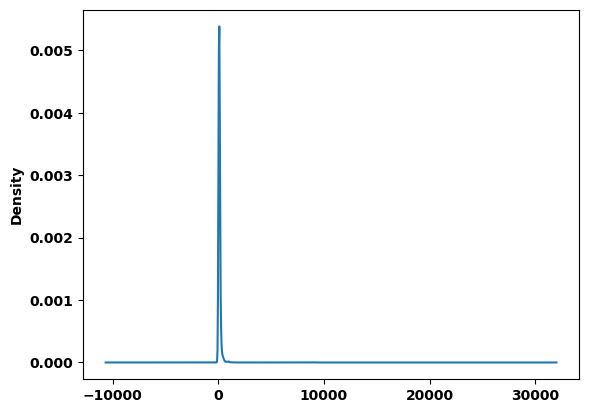

In [83]:
num.price.plot.kde()

Revisamos los máximos

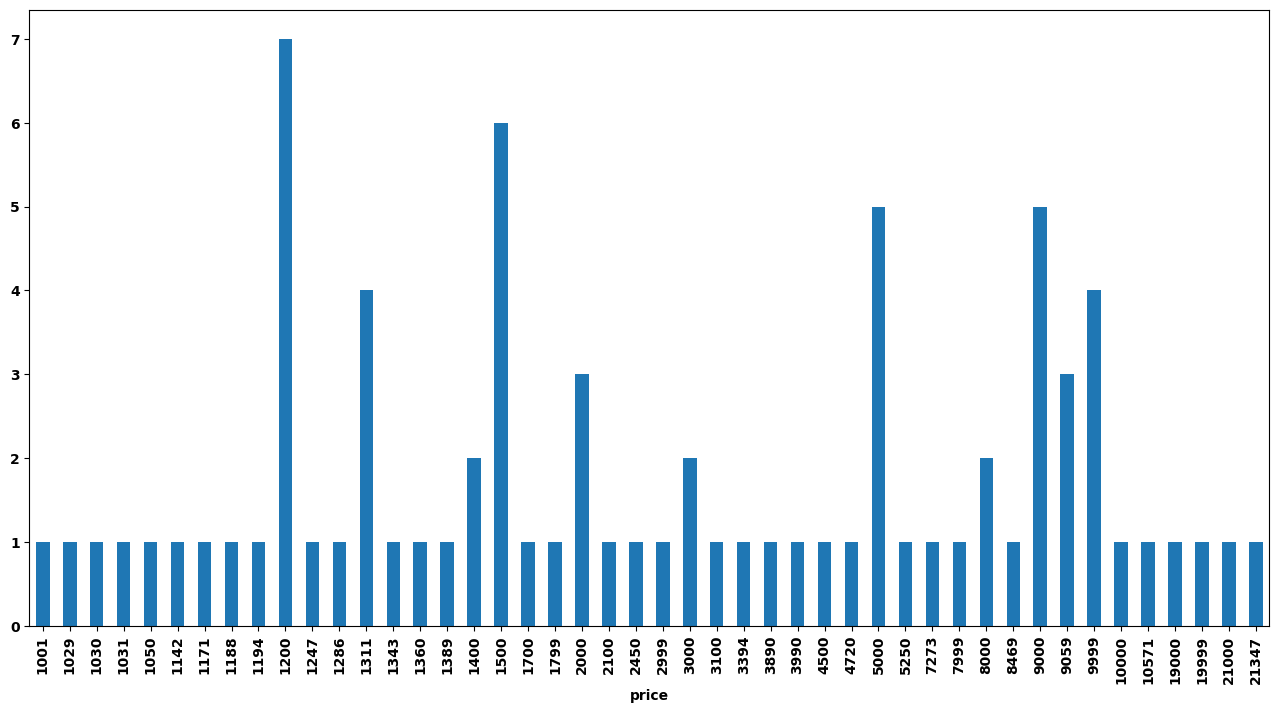

In [84]:
plt.figure(figsize=(16,8))
num.price.loc[num.price > 1000].value_counts().sort_index().plot.bar()
plt.xticks(size = 10);

Conclusión: 
    
* el valor 9999 normalmente suele ser una forma de imputar nulos, pero en este caso su frecuencia no está muy lejos de otros valores que pueden ser válidos, como el 8000, así que no lo vamos a tocar

Veremos en la representación sobre un mapa donde se encuentran los alojamientos ya que, por experiencia en el análisis de este tipo de información, podría decir que pueden ser alojamientos cercanos a lugares en fechas especiales como un piso cercano a un estadio durante la champions league o en la puerta del sol en fin de año

Revisamos los valores cercanos a cero

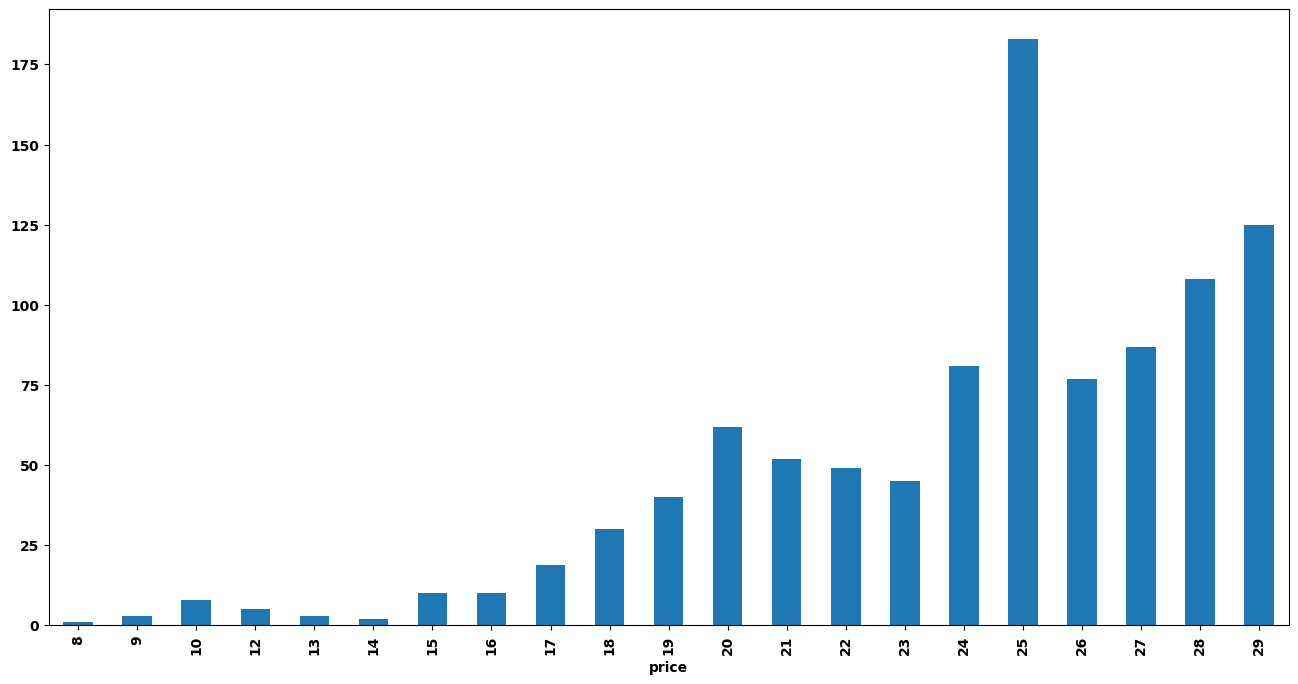

In [85]:
plt.figure(figsize=(16,8))
num.price.loc[num.price < 30].value_counts().sort_index().plot.bar()
plt.xticks(size = 10);

Conclusión: 
    
* Hay un pico en 20 euros, y parece que por debajo de esa cantidad sería difícil obtener rentabilidad, así que vamos a descartar los inmuebles que se alquilan por debajo de 20 euros

In [86]:
cat = cat.loc[num['price']>=20]
num = num.loc[num['price']>=20]

Calculamos los atípicos para minimun_nights y maximun_nights y retiramos los registros de ambos datasets

In [87]:
num.describe().T

,count,mean,min,25%,50%,75%,max,std
host_id,26625.00,250438725.93,7952.00,49735663.00,216310014.00,444912851.00,666359276.00,203524741.84
host_since,26625,2018-10-15 23:34:08.856337920,2009-02-15 00:00:00,2015-11-28 00:00:00,2018-09-19 00:00:00,2022-02-13 00:00:00,2024-12-10 00:00:00,NaN
host_response_rate,26625.00,74.47,0.00,64.00,100.00,100.00,100.00,40.78
host_acceptance_rate,26625.00,84.78,0.00,82.00,97.00,100.00,100.00,24.47
host_listings_count,26625.00,49.90,1.00,1.00,4.00,23.00,3251.00,133.90
host_total_listings_count,26625.00,60.80,1.00,2.00,5.00,30.00,7970.00,186.60
latitude,26625.00,40.42,40.33,40.41,40.42,40.43,40.54,0.02
longitude,26625.00,-3.69,-3.83,-3.71,-3.70,-3.68,-3.55,0.03
accommodates,26625.00,3.14,1.00,2.00,2.00,4.00,16.00,1.90
bathrooms,26625.00,1.28,0.00,1.00,1.00,1.50,15.00,0.63


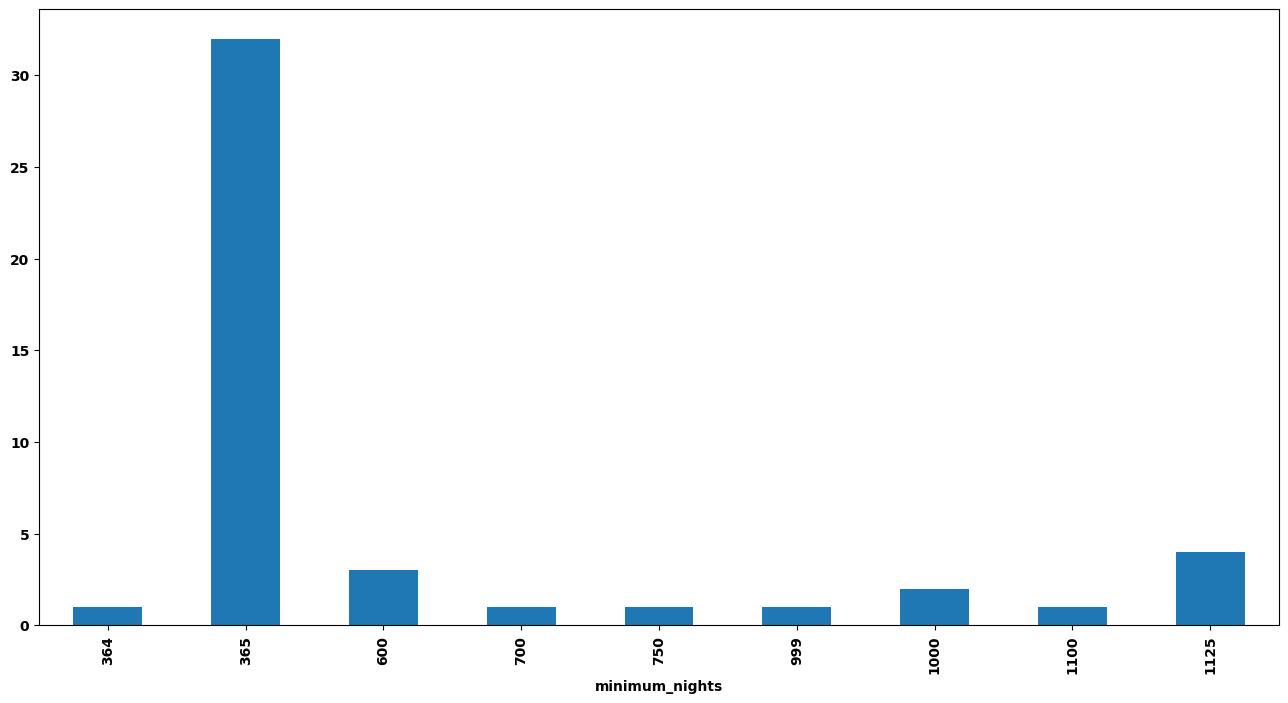

In [88]:
plt.figure(figsize=(16,8))
num.minimum_nights.loc[num.minimum_nights > 360].value_counts().sort_index().plot.bar()
plt.xticks(size = 10);

In [89]:
num.loc[num.minimum_nights > 360]

,host_id,host_since,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3855338,19887379,2014-08-12,0.00,85.00,1.00,1.00,40.43,-3.71,2,1.00,0.00,1.00,86,365,1125,0,0,0,0,6,0,0,2019-12-30,2020-03-02,4.50,4.83,4.67,5.00,5.00,4.83,4.67,1,0,1,0,0.10
5860795,15152516,2014-05-05,0.00,90.00,3.00,3.00,40.41,-3.72,2,1.00,0.00,1.00,104,1000,1125,30,60,90,90,160,0,0,2015-05-12,2020-10-29,4.83,4.91,4.90,4.94,4.92,4.82,4.87,1,0,1,0,1.37
5589621,10333945,2013-11-29,0.00,0.00,2.00,2.00,40.40,-3.71,1,1.00,1.00,0.00,20,365,365,0,0,0,194,24,0,0,2015-12-15,2019-07-11,4.88,4.88,4.83,4.83,4.96,4.71,4.83,2,0,2,0,0.22
6522322,15605156,2014-05-16,0.00,93.00,1.00,5.00,40.42,-3.70,2,1.00,1.00,2.00,63,365,1125,28,58,88,363,145,0,0,2015-06-01,2018-02-27,4.67,4.82,4.70,4.81,4.81,4.76,4.73,1,1,0,0,1.25
9473403,28404781,2015-02-26,0.00,88.00,2.00,2.00,40.43,-3.70,3,1.00,0.00,2.00,114,365,1125,23,53,83,358,78,0,0,2015-12-23,2017-09-25,4.91,4.93,4.99,4.97,4.97,4.97,4.90,2,2,0,0,0.71
9974417,51165124,2015-12-12,0.00,89.00,1.00,1.00,40.42,-3.70,3,1.00,1.00,2.00,124,750,1125,30,60,90,365,182,0,0,2015-12-21,2020-02-03,4.89,4.91,4.91,4.90,4.96,4.94,4.82,1,1,0,0,1.66
12086094,28404781,2015-02-26,0.00,88.00,2.00,2.00,40.43,-3.70,3,1.00,1.00,2.00,114,365,365,23,53,83,358,47,0,0,2016-04-24,2017-06-07,4.91,4.89,4.94,4.93,4.98,4.96,4.80,2,2,0,0,0.45
13267669,41237600,2015-08-12,0.00,70.00,1.00,1.00,40.44,-3.68,2,1.00,1.00,1.00,106,365,1125,0,0,0,0,0,0,0,2015-08-12,2015-08-12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,1,0,0,0.00
16287504,60115303,2016-02-23,0.00,80.00,1.00,1.00,40.39,-3.71,2,1.00,0.00,1.00,78,365,1125,0,0,0,0,51,0,0,2016-12-16,2017-10-01,4.65,4.76,4.76,4.92,4.80,4.56,4.70,1,0,1,0,0.52


In [90]:
#MINIMUM NIGHTS
#Definir el número de desviaciones típicas
num_desv_tip = 4

def atipicos_desv_tip(num, variable, num_desv_tip=4):
    # serie sin nulos
    serie = num[variable].dropna()
    media = np.mean(serie)
    sd = np.std(serie)
    umbral = sd * num_desv_tip
    lim_inf = media - umbral
    lim_sup = media + umbral
    # devuelve los índices que están fuera de los límites
    return serie[(serie < lim_inf) | (serie > lim_sup)].index


###### Función que cuenta el número de atípicos

In [91]:
def atipicos_minimum_nights(num,variable, num_desv_tip = 4):
    atipicos = atipicos_desv_tip(num, variable, num_desv_tip)
    return(num.loc[atipicos,variable].value_counts())

###### Variables a aplicar

In [92]:
variables_analizar = ['minimum_nights']

###### Aplicar

In [93]:
for variable in variables_analizar:
    print('\n' + variable + ':\n')
    print(atipicos_minimum_nights(num,variable,num_desv_tip).sort_index())


minimum_nights:

minimum_nights
140      1
150      7
155      1
160      3
179      1
180     25
186      1
190      4
200     11
211      1
222      1
225      1
240      1
270      1
289      1
300     17
305      1
330      1
333      1
360      4
364      1
365     32
600      3
700      1
750      1
999      1
1000     2
1100     1
1125     4
Name: count, dtype: int64


In [94]:
#MAXIMUN NIGHTS
#Definir el número de desviaciones típicas
num_desv_tip = 4

def atipicos_desv_tip(variable, num_desv_tip = 4):
    #sacamos los nulos por ahora
    variable = variable.dropna()
    #calculamos los límites
    media = np.mean(variable)
    sd = np.std(variable)
    umbral = sd * num_desv_tip
    lim_inf = media - umbral
    lim_sup = media + umbral
    #encontramos los índices de los que están fuera de los límites
    indices = [indice for indice,valor in variable.items() if valor < lim_inf or valor > lim_sup]
    return(indices)

###### Función que cuenta el número de atípicos

In [95]:
def atipicos_maximum_nights(num,variable, num_desv_tip = 4):
    atipicos = atipicos_desv_tip(num[variable], num_desv_tip)
    return(num.loc[atipicos,variable].value_counts())

###### Variables a aplicar

In [96]:
variables_analizar = ['maximum_nights']

###### Aplicar

In [97]:
for variable in variables_analizar:
    print('\n' + variable + ':\n')
    print(atipicos_maximum_nights(num,variable,num_desv_tip))


maximum_nights:

maximum_nights
11111    1
Name: count, dtype: int64


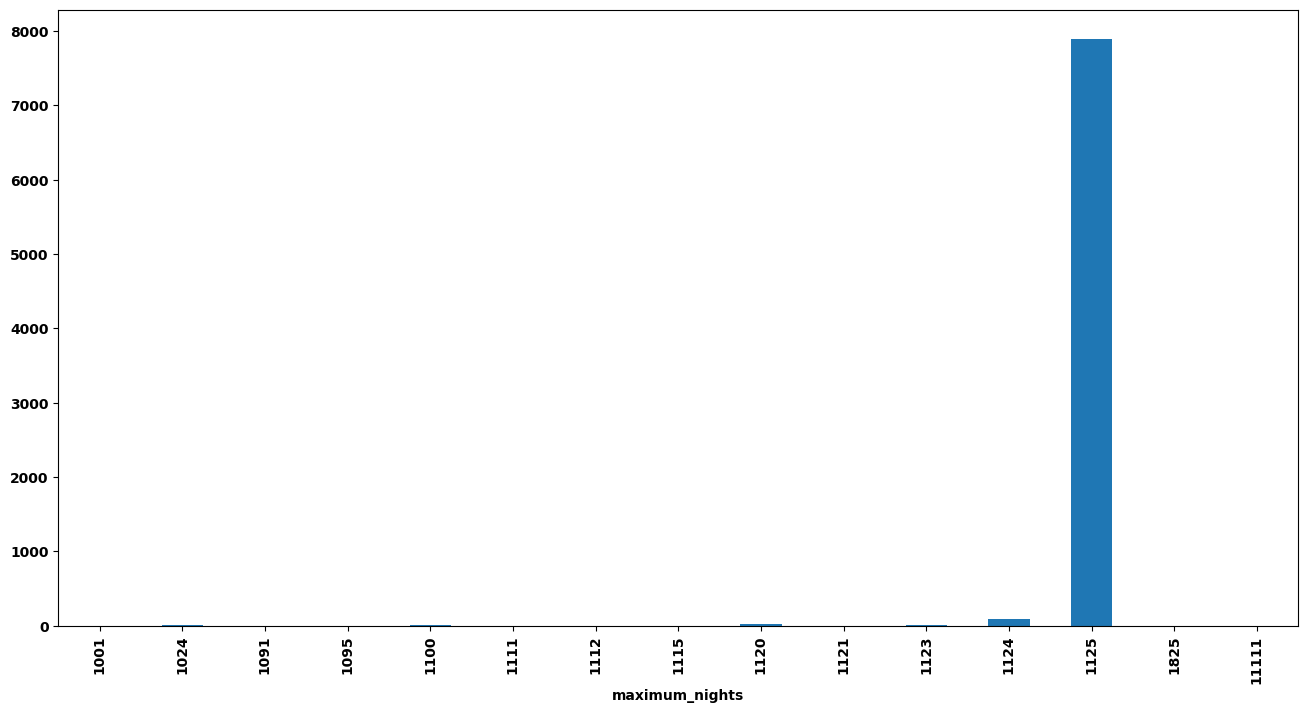

In [98]:
plt.figure(figsize=(16,8))
num.maximum_nights.loc[num.maximum_nights > 1000].value_counts().sort_index().plot.bar()
plt.xticks(size = 10);

In [99]:
num.maximum_nights.loc[num.maximum_nights > 1000].value_counts().sort_index()

maximum_nights
1001        1
1024        3
1091        1
1095        1
1100        5
1111        1
1112        1
1115        1
1120       15
1121        1
1123        6
1124       86
1125     7893
1825        1
11111       1
Name: count, dtype: int64

In [100]:
variables_analizar = ['maximum_nights']

In [101]:
cat = cat.loc[num['maximum_nights']<=1125]
num = num.loc[num['maximum_nights']<=1125]

In [102]:
cat

,name,host_response_time,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,amenities,has_availability,license,instant_bookable
id,,,,,,,,,,,,,
21853,Bright and airy room,no response,f,"['email', 'phone']",t,t,Cármenes,Private room in rental unit,Private room,"[""First aid kit"", ""Wifi"", ""Kitchen"", ""Essentia...",yes,no,f
30320,Great Vacational Apartments,no response,f,"['email', 'phone']",t,f,Sol,Entire rental unit,Entire home/apt,"[""Heating"", ""Wifi"", ""TV with standard cable"", ...",no,no,f
30959,Beautiful loft in Madrid Center,no response,f,"['email', 'phone']",t,f,Embajadores,Entire loft,Entire home/apt,"[""Breakfast"", ""Heating"", ""Wifi"", ""Smoking allo...",no,no,f
40916,Holiday Apartment Madrid Center,no response,f,"['email', 'phone']",t,f,Universidad,Entire rental unit,Entire home/apt,"[""Heating"", ""Wifi"", ""Pets allowed"", ""Kitchen"",...",no,no,f
62423,MAGIC ARTISTIC HOUSE IN THE CENTER OF MADRID,within an hour,f,"['email', 'phone']",t,t,Justicia,Private room in rental unit,Private room,"[""Books and reading material"", ""First aid kit""...",yes,no,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308816654087147793,Vive Madrid Río con Confort y Estilo,within a few hours,f,"['email', 'phone']",t,t,Puerta del Angel,Entire rental unit,Entire home/apt,"[""Wifi"", ""Kitchen"", ""Hot water"", ""Microwave"", ...",yes,no,t
1308818613904246041,Alquilo habitación por 15 días.,no response,f,"['email', 'phone']",t,t,Palacio,Private room in rental unit,Private room,"[""Wifi"", ""Kitchen"", ""TV""]",yes,no,f
1308839477505592914,Sierra Habitacion doble con Baño Privado,within an hour,f,"['email', 'phone']",t,t,Numancia,Room in hotel,Private room,"[""Exterior security cameras on property"", ""Smo...",yes,no,t


In [103]:
num.describe().T

,count,mean,min,25%,50%,75%,max,std
host_id,26623.00,250456500.31,7952.00,49903592.50,216310014.00,444912851.00,666359276.00,203522035.52
host_since,26623,2018-10-16 02:50:16.249107712,2009-02-15 00:00:00,2015-11-28 00:00:00,2018-09-19 00:00:00,2022-02-13 00:00:00,2024-12-10 00:00:00,NaN
host_response_rate,26623.00,74.48,0.00,64.00,100.00,100.00,100.00,40.78
host_acceptance_rate,26623.00,84.78,0.00,82.00,97.00,100.00,100.00,24.47
host_listings_count,26623.00,49.91,1.00,1.00,4.00,23.00,3251.00,133.90
host_total_listings_count,26623.00,60.80,1.00,2.00,5.00,30.00,7970.00,186.61
latitude,26623.00,40.42,40.33,40.41,40.42,40.43,40.54,0.02
longitude,26623.00,-3.69,-3.83,-3.71,-3.70,-3.68,-3.55,0.03
accommodates,26623.00,3.14,1.00,2.00,2.00,4.00,16.00,1.90
bathrooms,26623.00,1.28,0.00,1.00,1.00,1.50,15.00,0.63


Vamos a hacer una transformación en una de las variables porque lo necesitaremos de esta forma para generar el datamart analítico. El resto de las transformaciones necesarias serán para las predicciones y las haremos mas tarde.

Vemos que hay hoteles. Nuestron proyecto no sería para comprar un hotel, así que tenemos que eliminar estos registros.

Nota: En principio habíamos eliminado los room_type == 'Hotel' pero después hemos visto datos raros en la media del coste de las habitaciones y hemos indagado para saber porque era tan elevado el precio de las habitaciones compartidas y nos hemos dado cuenta que había property_type que eran hoteles o hostel por lo que los hemos vuelto a este notebook para eliminarlos de cat y avanzar hacia un df limpio

In [104]:
cat = cat.loc[~((cat.property_type.str.contains('hotel', case=False, na=False))|
               (cat.property_type.str.contains('hostel', case=False, na=False))|
               (cat.room_type.str.contains('hotel', case=False, na=False)))]
cat

,name,host_response_time,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,amenities,has_availability,license,instant_bookable
id,,,,,,,,,,,,,
21853,Bright and airy room,no response,f,"['email', 'phone']",t,t,Cármenes,Private room in rental unit,Private room,"[""First aid kit"", ""Wifi"", ""Kitchen"", ""Essentia...",yes,no,f
30320,Great Vacational Apartments,no response,f,"['email', 'phone']",t,f,Sol,Entire rental unit,Entire home/apt,"[""Heating"", ""Wifi"", ""TV with standard cable"", ...",no,no,f
30959,Beautiful loft in Madrid Center,no response,f,"['email', 'phone']",t,f,Embajadores,Entire loft,Entire home/apt,"[""Breakfast"", ""Heating"", ""Wifi"", ""Smoking allo...",no,no,f
40916,Holiday Apartment Madrid Center,no response,f,"['email', 'phone']",t,f,Universidad,Entire rental unit,Entire home/apt,"[""Heating"", ""Wifi"", ""Pets allowed"", ""Kitchen"",...",no,no,f
62423,MAGIC ARTISTIC HOUSE IN THE CENTER OF MADRID,within an hour,f,"['email', 'phone']",t,t,Justicia,Private room in rental unit,Private room,"[""Books and reading material"", ""First aid kit""...",yes,no,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308811268356474614,Habitación tranquila,within an hour,f,['phone'],t,t,Ventas,Private room in rental unit,Private room,"[""Wifi"", ""TV""]",yes,no,f
1308816654087147793,Vive Madrid Río con Confort y Estilo,within a few hours,f,"['email', 'phone']",t,t,Puerta del Angel,Entire rental unit,Entire home/apt,"[""Wifi"", ""Kitchen"", ""Hot water"", ""Microwave"", ...",yes,no,t
1308818613904246041,Alquilo habitación por 15 días.,no response,f,"['email', 'phone']",t,t,Palacio,Private room in rental unit,Private room,"[""Wifi"", ""Kitchen"", ""TV""]",yes,no,f


In [105]:
cat.room_type.value_counts()

room_type
Entire home/apt    17439
Private room        8251
Shared room          223
Name: count, dtype: int64

## DATAMART ANALITICO

Tenemos 2 tablas principales:

* listings
* listings_det que la tenemos separada en cat y num

Y sabemos que ambas comparten el campo id, por tanto podemos cruzarlas por él. La tabla principal es cat de listings_det, que tiene mas detalle y nos da datos adicionales.

Por tanto la tabla que ha de mandar en la integración es cat y le vamos a añadir la columna neighbourhood_group de listings que es la información que nos falta para poder cuadrarlo con los distritos de la tabla de los precios por m2 de Idealista.

Aunque no hemos comprobado todavía que los literales sean iguales, por tanto quizá será necesario hacer alguna corrección manual.

Vamos a empezar por las 2 principales.

Dado que va a mandar la tabla cat el resultado final tendrá que tener tantas filas como cat y añadirle la columna neighbourhood_group de listings

In [106]:
listings.shape

(26760, 19)

In [107]:
cat.shape

(25913, 13)

Sacamos los valores de neighbourhood_group de listings que son los mismos que que tendra que tener cat

En listings la variable es categórica, así que para sacar los niveles tenemos que usar .categories

In [108]:
distritos1 = pd.Series(listings.neighbourhood_group.unique()).sort_values()
distritos1

8                Arganzuela
5                   Barajas
7               Carabanchel
1                    Centro
9                 Chamartín
4                  Chamberí
10            Ciudad Lineal
13    Fuencarral - El Pardo
12                Hortaleza
0                    Latina
15        Moncloa - Aravaca
19                Moratalaz
14       Puente de Vallecas
3                    Retiro
2                 Salamanca
16    San Blas - Canillejas
17                   Tetuán
6                     Usera
20                Vicálvaro
11        Villa de Vallecas
18               Villaverde
dtype: object

In [109]:
distritos2 = precio_m2.distrito
distritos2

1             Arganzuela
2                Barajas
3            Carabanchel
4                 Centro
5              Chamartín
6               Chamberí
7          Ciudad Lineal
8             Fuencarral
9              Hortaleza
10                Latina
11               Moncloa
12             Moratalaz
13    Puente de Vallecas
14                Retiro
15             Salamanca
16              San Blas
17                Tetuán
18                 Usera
19             Vicálvaro
20     Villa de Vallecas
21            Villaverde
Name: distrito, dtype: object

Vamos a realizar una función específica que una las tablas cat y listings por id, teniendo en cuenta que puede haber datos faltantes que deje neighbourhood_group como nulos, por lo que hacemos un mapeo de los nulos con neighbourhood_cleansed iguales y rellenamos los nulos. 

Después igualamos los nombres de cat con precio_m2 y hacemos un left_join entre cat y precio_m2 por neighbourhood_group/distrito

Por último, hacemos otra función específica que haga un join entre cat y num para llevar la columna precio_m2 a num y la borramos de cat porque es una columna numérica

Integramos ambas funciones en una función padre

In [127]:
pd.merge(left=listings_det, right=listings[['id', 'neighbourhood_group']], how='left', on='id')

,id,name,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,neighbourhood_group
0,21853,Bright and airy room,83531,2010-02-21,no response,0.00,0.00,f,2.00,2.00,"['email', 'phone']",t,t,Cármenes,40.40,-3.74,Private room in rental unit,Private room,1,1.00,1.00,1.00,"[""First aid kit"", ""Wifi"", ""Kitchen"", ""Essentia...",31,4,40,yes,0,0,0,144,33,0,0,2014-10-10,2018-07-15,4.58,4.72,4.56,4.75,4.82,4.21,4.67,no,f,2,0,2,0,0.27,Latina
1,30320,Great Vacational Apartments,130907,2010-05-24,no response,0.00,93.00,f,3.00,6.00,"['email', 'phone']",t,f,Sol,40.41,-3.70,Entire rental unit,Entire home/apt,2,1.00,1.00,1.00,"[""Heating"", ""Wifi"", ""TV with standard cable"", ...",149,5,180,no,0,0,0,0,172,0,0,2010-07-06,2022-09-26,4.63,4.71,4.88,4.82,4.78,4.90,4.69,no,f,3,3,0,0,0.98,Centro
2,30959,Beautiful loft in Madrid Center,132883,2010-05-26,no response,0.00,88.00,f,1.00,4.00,"['email', 'phone']",t,f,Embajadores,40.41,-3.70,Entire loft,Entire home/apt,2,1.00,1.00,1.00,"[""Breakfast"", ""Heating"", ""Wifi"", ""Smoking allo...",92,3,730,no,0,0,0,0,8,0,0,2015-05-12,2017-05-30,4.38,4.14,4.38,4.63,4.63,4.88,4.25,no,f,1,1,0,0,0.07,Centro
3,40916,Holiday Apartment Madrid Center,130907,2010-05-24,no response,0.00,89.00,f,3.00,6.00,"['email', 'phone']",t,f,Universidad,40.42,-3.71,Entire rental unit,Entire home/apt,3,1.00,1.00,2.00,"[""Heating"", ""Wifi"", ""Pets allowed"", ""Kitchen"",...",124,5,180,no,0,0,0,0,49,0,0,2010-11-01,2021-12-11,4.65,4.69,4.90,4.85,4.79,4.88,4.55,no,f,3,3,0,0,0.29,Centro
4,62423,MAGIC ARTISTIC HOUSE IN THE CENTER OF MADRID,303845,2010-11-29,within an hour,100.00,100.00,f,3.00,3.00,"['email', 'phone']",t,t,Justicia,40.42,-3.70,Private room in rental unit,Private room,4,1.50,1.00,2.00,"[""Books and reading material"", ""First aid kit""...",69,1,30,yes,13,37,59,332,219,44,3,2018-05-10,2024-11-24,4.64,4.78,4.42,4.79,4.85,4.97,4.58,no,f,3,1,2,0,2.73,Centro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26751,1308816654087147793,Vive Madrid Río con Confort y Estilo,251333188,2019-03-26,within a few hours,100.00,67.00,f,163.00,234.00,"['email', 'phone']",t,t,Puerta del Angel,40.41,-3.72,Entire rental unit,Entire home/apt,4,1.00,1.00,2.00,"[""Wifi"", ""Kitchen"", ""Hot water"", ""Microwave"", ...",258,1,365,yes,15,45,75,350,0,0,0,2019-03-26,2019-03-26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,no,t,19,19,0,0,0.00,Latina
26752,1308818613904246041,Alquilo habitación por 15 días.,118339834,2017-02-27,no response,0.00,90.00,f,1.00,1.00,"['email', 'phone']",t,t,Palacio,40.41,-3.71,Private room in rental unit,Private room,1,1.00,1.00,1.00,"[""Wifi"", ""Kitchen"", ""TV""]",20,15,16,yes,29,59,89,364,0,0,0,2017-02-27,2017-02-27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,no,f,1,0,1,0,0.00,Centro
26753,1308839477505592914,Sierra Habitacion doble con Baño Privado,23441165,2014-11-07,within an hour,95.00,98.00,f,39.00,90.00,"['email', 'phone']",t,t,Numancia,40.40,-3.66,Room in hotel,Private room,2,1.00,1.00,1.00,"[""Exterior security cameras on property"", ""Smo...",69,1,

In [111]:
def union_tablas(cat, num, listings, precio_m2):  
    nuevos_neighbourhood_group = {'Fuencarral - El Pardo': 'Fuencarral',
                                  'Moncloa - Aravaca': 'Moncloa',
                                  'San Blas - Canillejas': 'San Blas'
                                 }

    def joins_cat(cat, listings, precio_m2):
        cat = pd.merge(left=cat, right=listings[['id', 'neighbourhood_group']], how='left', on='id')
        mapeo = (
            cat[cat['neighbourhood_group'].notna()]
            .drop_duplicates(subset='neighbourhood_cleansed')
            .set_index('neighbourhood_cleansed')['neighbourhood_group']
            .to_dict()
        )
        cat['neighbourhood_group'] = cat.apply(
            lambda row: mapeo.get(row['neighbourhood_cleansed'], row['neighbourhood_group'])
            if pd.isna(row['neighbourhood_group']) else row['neighbourhood_group'],
            axis=1
        )
        cat['neighbourhood_group'] = cat['neighbourhood_group'].replace(nuevos_neighbourhood_group)

        cat = pd.merge(left=cat, right=precio_m2, how='left',
                       left_on='neighbourhood_group', right_on='distrito')\
                 .drop(columns='distrito')       
        return cat

    def joins_num(num, cat):
        num = pd.merge(left=num, right=cat[['id', 'precio_m2']], how='inner', on='id')
        cat.drop(columns='precio_m2', inplace=True)
        return num

    cat = joins_cat(cat, listings, precio_m2)
    num = joins_num(num, cat)

    return cat, num
cat, num = union_tablas(cat, num, listings, precio_m2)

In [112]:
cat

,id,name,host_response_time,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,amenities,has_availability,license,instant_bookable,neighbourhood_group
0,21853,Bright and airy room,no response,f,"['email', 'phone']",t,t,Cármenes,Private room in rental unit,Private room,"[""First aid kit"", ""Wifi"", ""Kitchen"", ""Essentia...",yes,no,f,Latina
1,30320,Great Vacational Apartments,no response,f,"['email', 'phone']",t,f,Sol,Entire rental unit,Entire home/apt,"[""Heating"", ""Wifi"", ""TV with standard cable"", ...",no,no,f,Centro
2,30959,Beautiful loft in Madrid Center,no response,f,"['email', 'phone']",t,f,Embajadores,Entire loft,Entire home/apt,"[""Breakfast"", ""Heating"", ""Wifi"", ""Smoking allo...",no,no,f,Centro
3,40916,Holiday Apartment Madrid Center,no response,f,"['email', 'phone']",t,f,Universidad,Entire rental unit,Entire home/apt,"[""Heating"", ""Wifi"", ""Pets allowed"", ""Kitchen"",...",no,no,f,Centro
4,62423,MAGIC ARTISTIC HOUSE IN THE CENTER OF MADRID,within an hour,f,"['email', 'phone']",t,t,Justicia,Private room in rental unit,Private room,"[""Books and reading material"", ""First aid kit""...",yes,no,f,Centro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25908,1308811268356474614,Habitación tranquila,within an hour,f,['phone'],t,t,Ventas,Private room in rental unit,Private room,"[""Wifi"", ""TV""]",yes,no,f,Ciudad Lineal
25909,1308816654087147793,Vive Madrid Río con Confort y Estilo,within a few hours,f,"['email', 'phone']",t,t,Puerta del Angel,Entire rental unit,Entire home/apt,"[""Wifi"", ""Kitchen"", ""Hot water"", ""Microwave"", ...",yes,no,t,Latina
25910,1308818613904246041,Alquilo habitación por 15 días.,no response,f,"['email', 'phone']",t,t,Palacio,Private room in rental unit,Private room,"[""Wifi"", ""Kitchen"", ""TV""]",yes,no,f,Centro
25911,1308842708819314249,Estudio luminoso y renovado junto a Madrid Río,within a few hours,f,"['email', 'phone']",t,t,Puerta del Angel,Entire rental unit,Entire home/apt,"[""Wifi"", ""Kitchen"", ""Hot water"", ""Microwave"", ...",yes,no,t,Latina


In [112]:
cat

,id,name,host_response_time,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,amenities,has_availability,license,instant_bookable,neighbourhood_group
0,21853,Bright and airy room,no response,f,"['email', 'phone']",t,t,Cármenes,Private room in rental unit,Private room,"[""First aid kit"", ""Wifi"", ""Kitchen"", ""Essentia...",yes,no,f,Latina
1,30320,Great Vacational Apartments,no response,f,"['email', 'phone']",t,f,Sol,Entire rental unit,Entire home/apt,"[""Heating"", ""Wifi"", ""TV with standard cable"", ...",no,no,f,Centro
2,30959,Beautiful loft in Madrid Center,no response,f,"['email', 'phone']",t,f,Embajadores,Entire loft,Entire home/apt,"[""Breakfast"", ""Heating"", ""Wifi"", ""Smoking allo...",no,no,f,Centro
3,40916,Holiday Apartment Madrid Center,no response,f,"['email', 'phone']",t,f,Universidad,Entire rental unit,Entire home/apt,"[""Heating"", ""Wifi"", ""Pets allowed"", ""Kitchen"",...",no,no,f,Centro
4,62423,MAGIC ARTISTIC HOUSE IN THE CENTER OF MADRID,within an hour,f,"['email', 'phone']",t,t,Justicia,Private room in rental unit,Private room,"[""Books and reading material"", ""First aid kit""...",yes,no,f,Centro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25908,1308811268356474614,Habitación tranquila,within an hour,f,['phone'],t,t,Ventas,Private room in rental unit,Private room,"[""Wifi"", ""TV""]",yes,no,f,Ciudad Lineal
25909,1308816654087147793,Vive Madrid Río con Confort y Estilo,within a few hours,f,"['email', 'phone']",t,t,Puerta del Angel,Entire rental unit,Entire home/apt,"[""Wifi"", ""Kitchen"", ""Hot water"", ""Microwave"", ...",yes,no,t,Latina
25910,1308818613904246041,Alquilo habitación por 15 días.,no response,f,"['email', 'phone']",t,t,Palacio,Private room in rental unit,Private room,"[""Wifi"", ""Kitchen"", ""TV""]",yes,no,f,Centro
25911,1308842708819314249,Estudio luminoso y renovado junto a Madrid Río,within a few hours,f,"['email', 'phone']",t,t,Puerta del Angel,Entire rental unit,Entire home/apt,"[""Wifi"", ""Kitchen"", ""Hot water"", ""Microwave"", ...",yes,no,t,Latina


In [113]:
cat.neighbourhood_group.value_counts(dropna=False).sort_index()

neighbourhood_group
Arganzuela             1405
Barajas                 185
Carabanchel             984
Centro                10511
Chamartín               850
Chamberí               1679
Ciudad Lineal           962
Fuencarral              386
Hortaleza               520
Latina                  699
Moncloa                 692
Moratalaz               190
Puente de Vallecas      807
Retiro                  963
Salamanca              1769
San Blas                592
Tetuán                 1619
Usera                   609
Vicálvaro                88
Villa de Vallecas       137
Villaverde              266
Name: count, dtype: int64

In [114]:
num

,id,host_id,host_since,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,precio_m2
0,21853,83531,2010-02-21,0.00,0.00,2.00,2.00,40.40,-3.74,1,1.00,1.00,1.00,31,4,40,0,0,0,144,33,0,0,2014-10-10,2018-07-15,4.58,4.72,4.56,4.75,4.82,4.21,4.67,2,0,2,0,0.27,2772
1,30320,130907,2010-05-24,0.00,93.00,3.00,6.00,40.41,-3.70,2,1.00,1.00,1.00,149,5,180,0,0,0,0,172,0,0,2010-07-06,2022-09-26,4.63,4.71,4.88,4.82,4.78,4.90,4.69,3,3,0,0,0.98,6170
2,30959,132883,2010-05-26,0.00,88.00,1.00,4.00,40.41,-3.70,2,1.00,1.00,1.00,92,3,730,0,0,0,0,8,0,0,2015-05-12,2017-05-30,4.38,4.14,4.38,4.63,4.63,4.88,4.25,1,1,0,0,0.07,6170
3,40916,130907,2010-05-24,0.00,89.00,3.00,6.00,40.42,-3.71,3,1.00,1.00,2.00,124,5,180,0,0,0,0,49,0,0,2010-11-01,2021-12-11,4.65,4.69,4.90,4.85,4.79,4.88,4.55,3,3,0,0,0.29,6170
4,62423,303845,2010-11-29,100.00,100.00,3.00,3.00,40.42,-3.70,4,1.50,1.00,2.00,69,1,30,13,37,59,332,219,44,3,2018-05-10,2024-11-24,4.64,4.78,4.42,4.79,4.85,4.97,4.58,3,1,2,0,2.73,6170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25908,1308811268356474614,548687839,2023-11-29,100.00,69.00,1.00,2.00,40.43,-3.65,2,1.00,1.00,1.00,85,5,15,30,60,90,365,0,0,0,2023-11-29,2023-11-29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,0,1,0,0.00,3676
25909,1308816654087147793,251333188,2019-03-26,100.00,67.00,163.00,234.00,40.41,-3.72,4,1.00,1.00,2.00,258,1,365,15,45,75,350,0,0,0,2019-03-26,2019-03-26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19,19,0,0,0.00,2772
25910,1308818613904246041,118339834,2017-02-27,0.00,90.00,1.00,1.00,40.41,-3.71,1,1.00,1.00,1.00,20,15,16,29,59,89,364,0,0,0,2017-02-27,2017-02-27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,0,1,0,0.00,6170
25911,1308842708819314249,251333188,2019-03-26,100.00,67.00,163.00,234.00,40.41,-3.72,2,1.00,1.00,2.00,258,1,365,13,43,73,348,0,0,0,2019-03-26,2019-03-26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19,19,0,0,0.00,2772


Comprobamos que no se hayan generado nulos en la unión.

In [115]:
cat.neighbourhood_group.isna().sum()

0

In [116]:
num.precio_m2.isna().sum()

0

## GUARDAR EN LA BASE DE DATOS

Ahora que ya tenemos el tablón de análisis vamos a guardarlo en la base de datos para que cada vez que queramos hacer análisis no tengamos que repetir todo el procesamiento de este notebook

In [117]:
cat.to_sql('cat', con = con, if_exists = 'replace')
num.to_sql('num', con = con, if_exists = 'replace')
precio_m2.to_sql('precio_m2', con = con, if_exists = 'replace')


21

**TRANSFORMACIÓN DE VARIABLES**

La transformación de variables es una fase posterior pero la dejamos aquí reflejada como recordatorio de lo que posiblemente haya que hacer:

* name: Nada
* host_response_time: OrdinalEncoding
* host_is_superhost: OrdinalEncoding
* host_verifications: OrdinalEncoding
* host_has_profile_pic: OrdinalEncoding
* host_identity_verified: OrdinalEncoding
* neighbourhood_cleansed: OneHotEncoding
* property_type: OneHotEncoding
* room_type: OneHotEncoding
* amenities: Hay que separar los componentes en columnas + OneHotEncoding
* has_availability: OrdinalEncoding
* license: OrdinalEncoding
* instant_bookable: OrdinalEncoding